In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from score import collect_data, score
import os
from scipy import stats
import math
import seaborn as sns

# Load all Data

In [16]:
df_list = []
folders = os.listdir("kalin_data")
for folder in folders:
    if not os.path.isdir(os.path.join("kalin_data", folder)):
        continue
    if os.path.exists(f"kalin_data/{folder}/analysis_df_kalin.feather"):
        df_list.append(pd.read_feather(f"kalin_data/{folder}/analysis_df_kalin.feather"))

full_df = pd.concat(df_list)

# Fixing the df

lower_bound = 0
upper_bound = 1
m = (lower_bound-upper_bound)/75
full_df["ang_mult"] = (full_df["p1_ang"].values + full_df["p2_ang"].values)*.5  * ((180/math.pi) * m) + upper_bound
full_df["at_mult"] = (full_df["p1_at"].values + full_df["p2_at"].values)*.5


# print(full_df.shape)
# print(full_df.columns)

for l in ["SPEECH", "TURN"]:
    for m in ["TCN","BLSTM"]:
        for f in ["SYNCNET","PERFECTMATCH"]:
            for n in ["1LAYER","2LAYER"]:
                full_df[f'{n}_{l}_{m}_{f}'] = math.e**full_df[f'{n}_{l}_{m}_{f}-1Conf'].values
                full_df.drop([f'{n}_{l}_{m}_{f}-0Conf', f'{n}_{l}_{m}_{f}-1Conf'], axis=1, inplace=True)
#                 plt.show()


print(full_df.shape)
print(full_df.columns)


pose = ["pose_Rx", "pose_Ry"]
original_conf = ["sConf","pConf"]
speech_conf = [c for c in full_df.columns if "-SPEECH" in c]
turn_conf = [c for c in full_df.columns if "-TURN" in c]
ang = ["p1_ang","p2_ang"]
at = ["p1_at","p2_at"]
mult = ["ang_mult","at_mult"]


# display(full_df)

(1026144, 28)
Index(['SPEECH-LABEL', 'TURN-LABEL', 'sConf', 'pConf', 'p1_ang', 'p2_ang',
       'p1_at', 'p2_at', 'pose_Rx', 'pose_Ry', 'ang_mult', 'at_mult',
       '1LAYER_SPEECH_TCN_SYNCNET', '2LAYER_SPEECH_TCN_SYNCNET',
       '1LAYER_SPEECH_TCN_PERFECTMATCH', '2LAYER_SPEECH_TCN_PERFECTMATCH',
       '1LAYER_SPEECH_BLSTM_SYNCNET', '2LAYER_SPEECH_BLSTM_SYNCNET',
       '1LAYER_SPEECH_BLSTM_PERFECTMATCH', '2LAYER_SPEECH_BLSTM_PERFECTMATCH',
       '1LAYER_TURN_TCN_SYNCNET', '2LAYER_TURN_TCN_SYNCNET',
       '1LAYER_TURN_TCN_PERFECTMATCH', '2LAYER_TURN_TCN_PERFECTMATCH',
       '1LAYER_TURN_BLSTM_SYNCNET', '2LAYER_TURN_BLSTM_SYNCNET',
       '1LAYER_TURN_BLSTM_PERFECTMATCH', '2LAYER_TURN_BLSTM_PERFECTMATCH'],
      dtype='object')


## Visualize the Data

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


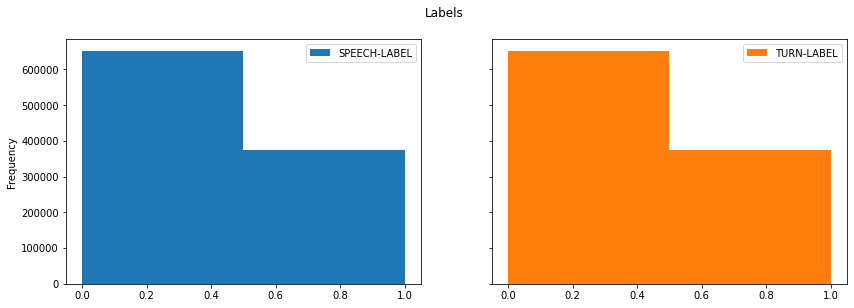

In [18]:
s=(14,4.5)
full_df[['SPEECH-LABEL', 'TURN-LABEL']].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Labels',bins=2, layout=[1,2],figsize=s)
plt.show()

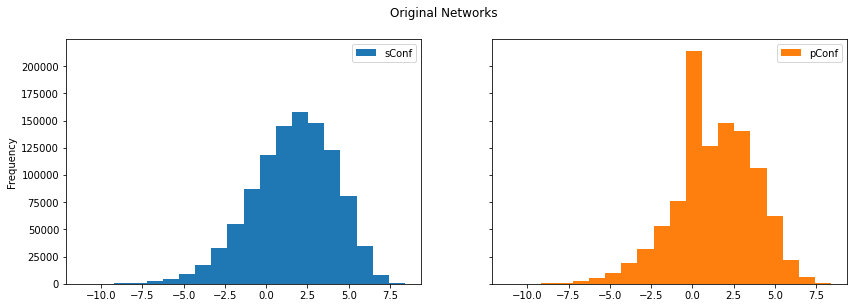

In [19]:
full_df[["sConf","pConf"]].plot(kind='hist',subplots=True,sharey=True,title=f'Original Networks',bins=20,layout=[1,2],figsize=s)
plt.show()

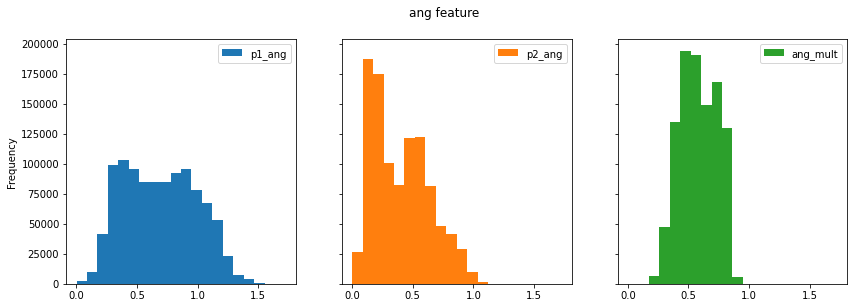

In [20]:
full_df[["p1_ang","p2_ang", "ang_mult"]].plot(kind='hist',subplots=True,sharey=True,title=f'ang feature',bins=20,layout=[1,3],figsize=s)
plt.show()

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


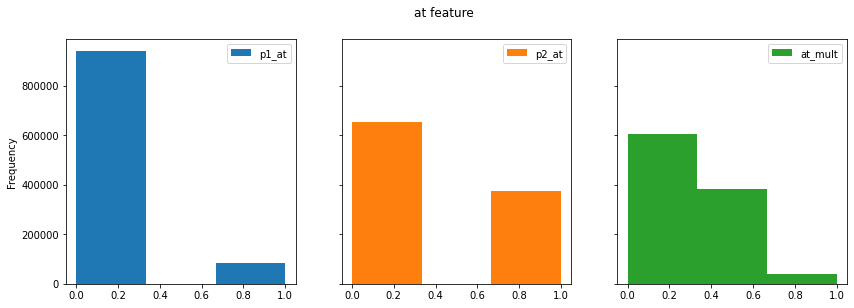

In [52]:
full_df[["p1_at","p2_at","at_mult"]].plot(kind='hist',subplots=True,sharey=True,title=f'at feature',bins=3,layout=[1,3],figsize=s)
plt.show()

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


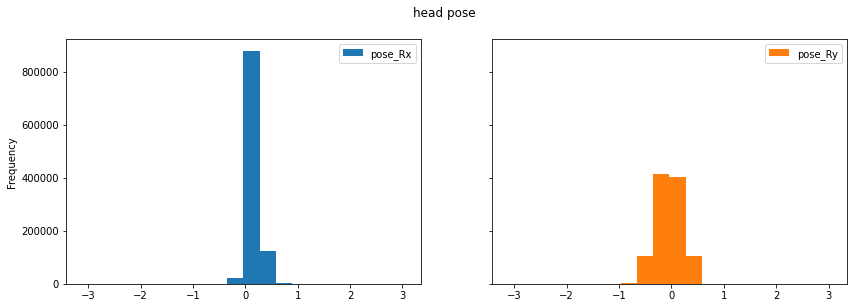

-86.34473972621505 83.82372542763945
-178.7055363013038 174.40835283782258


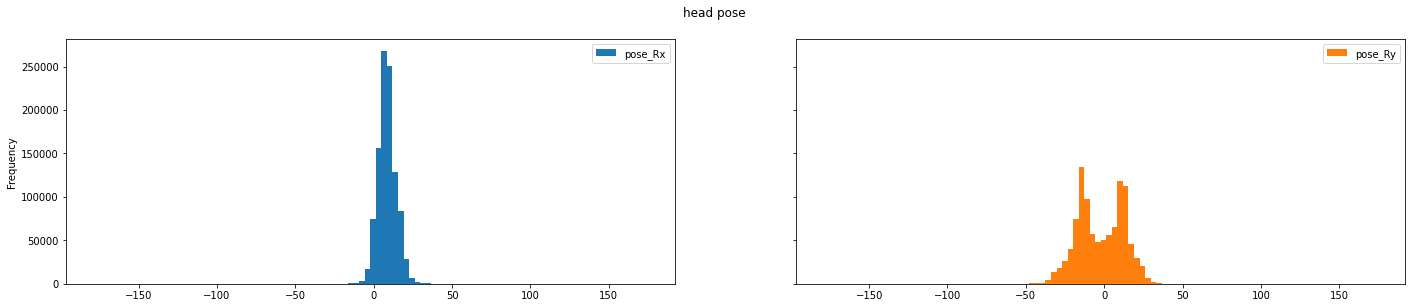

In [84]:
copy = full_df[["pose_Rx","pose_Ry"]] * 180/math.pi
full_df[["pose_Rx","pose_Ry"]].plot(kind='hist',subplots=True,sharey=True,title=f'head pose',bins=20,layout=[1,2],figsize=s)
plt.show()
copy.plot(kind='hist',subplots=True,sharey=True,title=f'head pose',bins=100,layout=[1,2],figsize=(24,4.5))
print(copy["pose_Ry"].min(),copy["pose_Ry"].max())
print(copy["pose_Rx"].min(),copy["pose_Rx"].max())
plt.show()

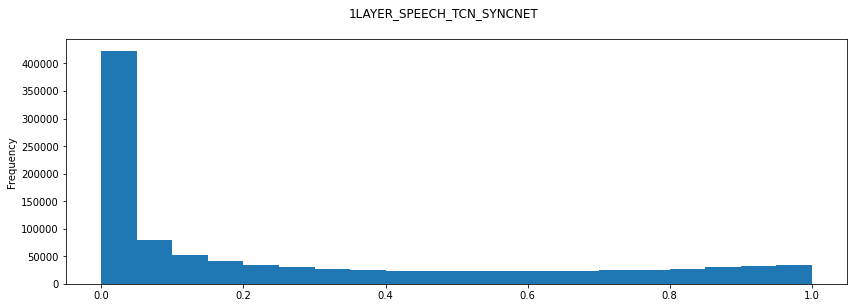

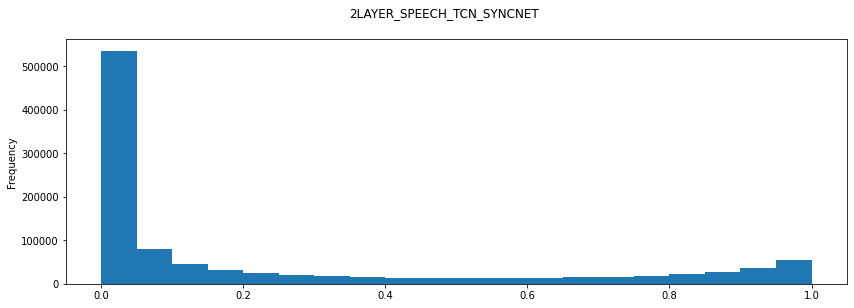

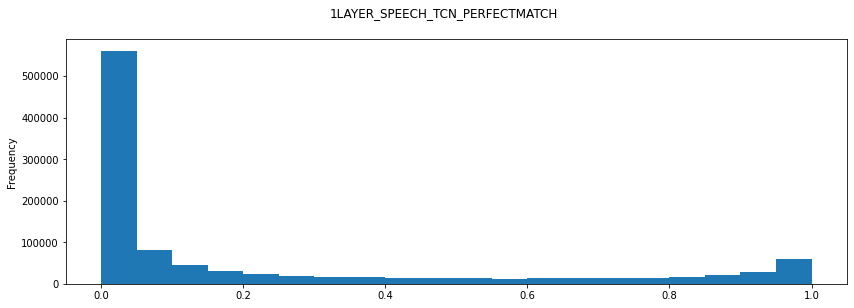

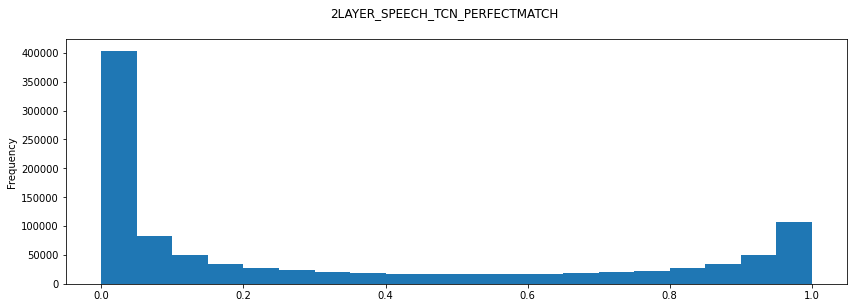

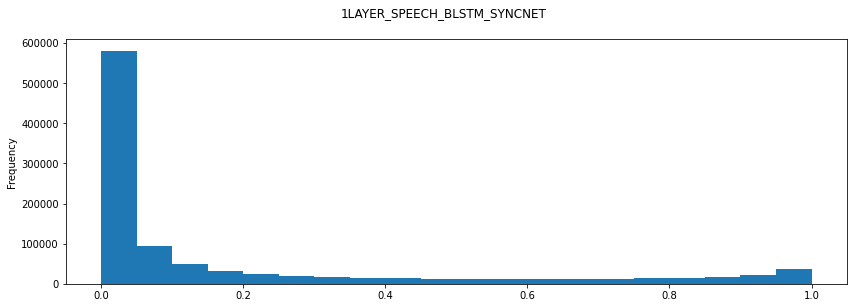

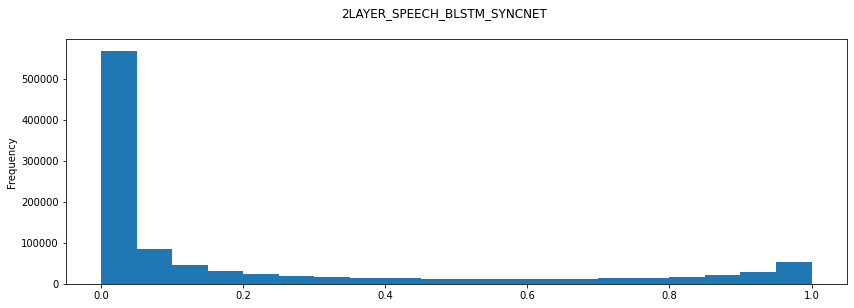

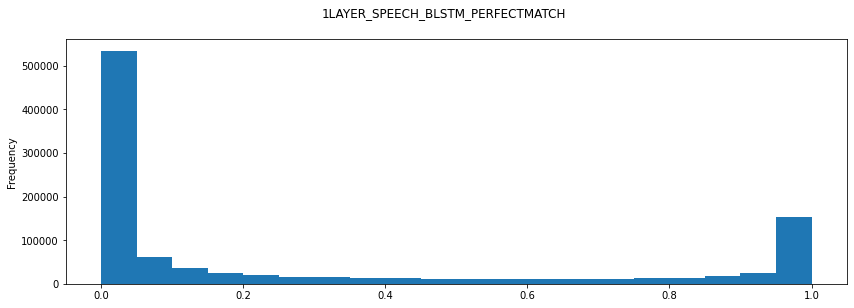

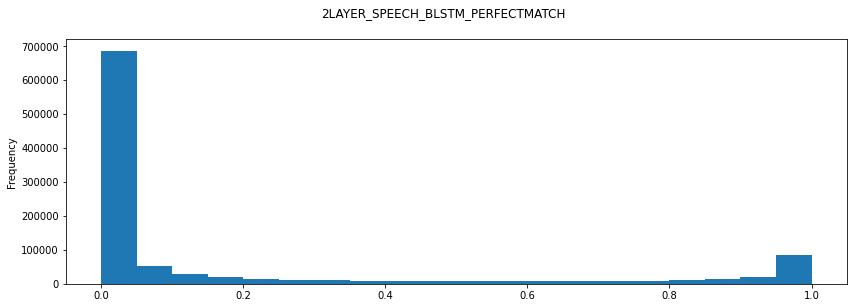

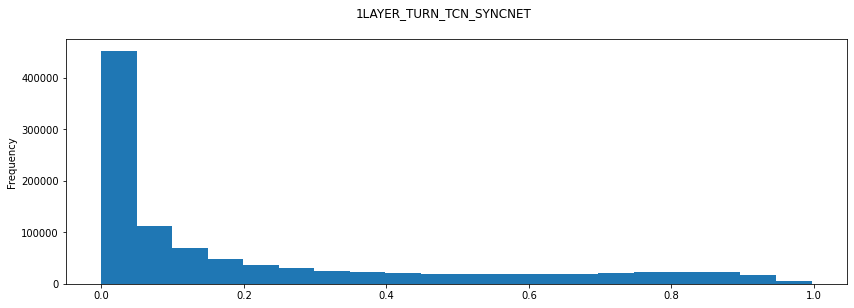

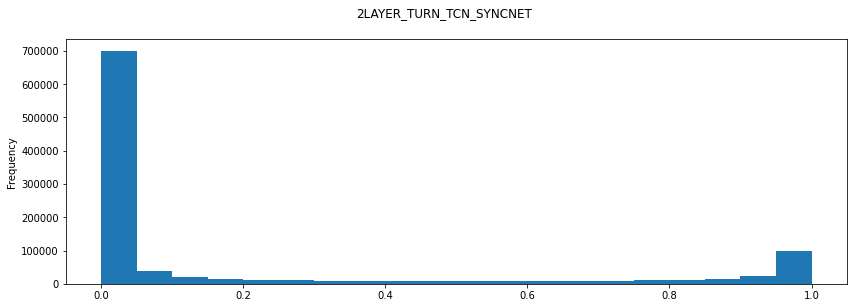

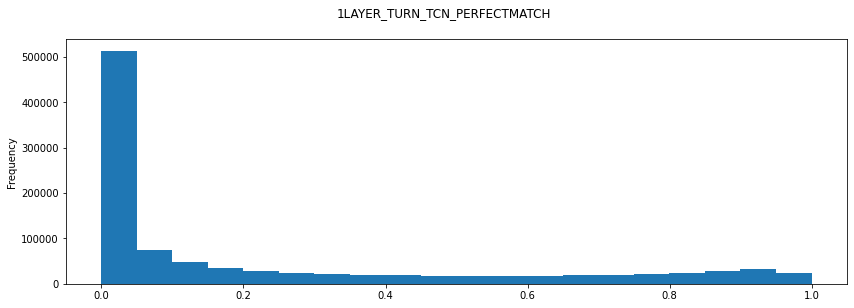

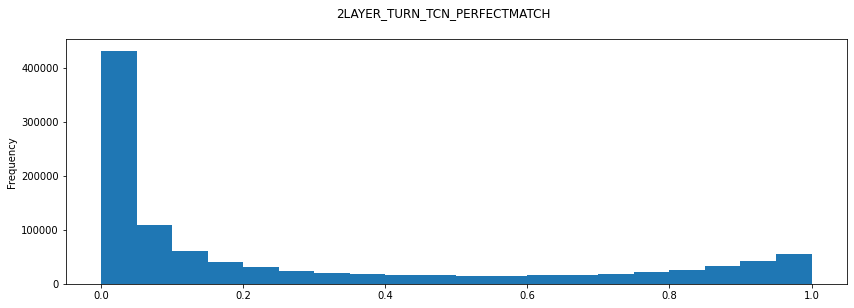

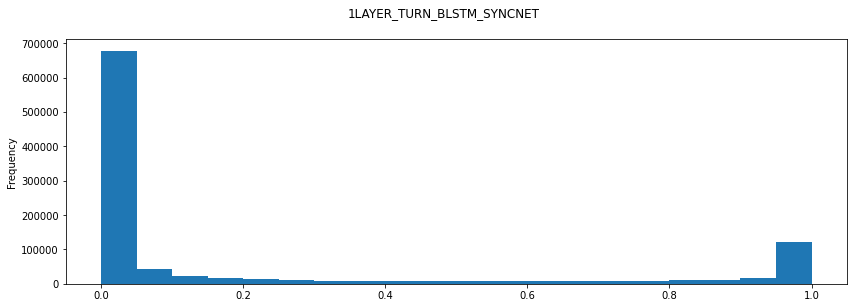

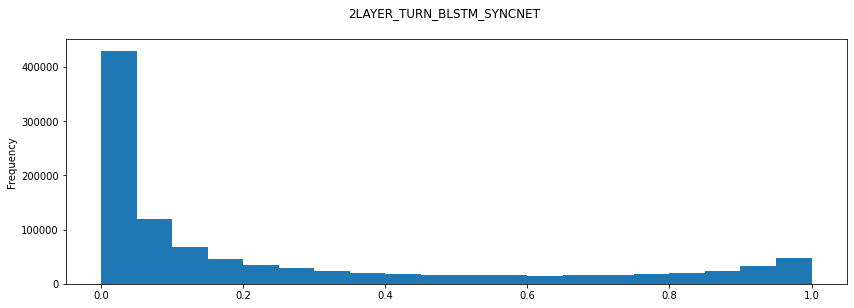

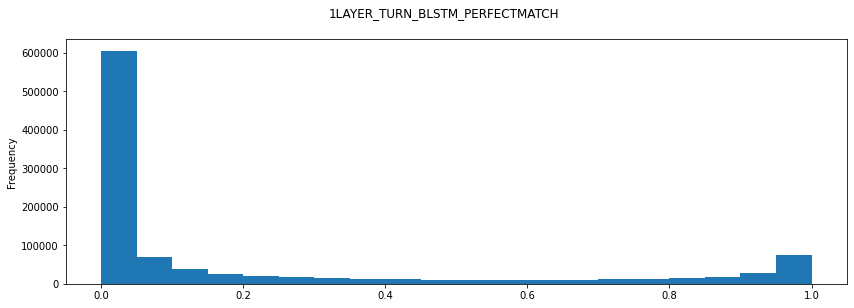

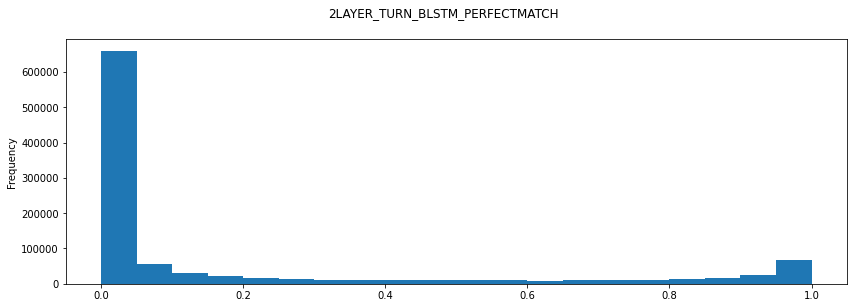

In [11]:
for l in ["SPEECH", "TURN"]:
    for m in ["TCN","BLSTM"]:
        for f in ["SYNCNET","PERFECTMATCH"]:
            for n in ["1LAYER","2LAYER"]:
                full_df[f'{n}_{l}_{m}_{f}'].plot(kind='hist',subplots=True,sharey=True,title=f'{n}_{l}_{m}_{f}',bins=20,layout=[1,1],figsize=s) 
                plt.show()

# Score Data

In [23]:
def score_df(df, label="SPEECH",print_df=True, plot=False):
    #acc, f1, auroc, mAP = score(targets, outputs)
    scores = {}
    # Score original models
    for m in ["sConf","pConf"]:
        outputs1 = df[m].values
        outputs0 = -1* df[m].values
        outputs = np.array(list(zip(outputs0,outputs1)), dtype=object)

        acc, f1, auroc, mAP = score(df[f"{label}-LABEL"].values, outputs)
        scores[m] = {"acc":acc,"f1":f1,"auROC":auroc,"mAP":mAP}
        
    # Score Gaze Features   
    outputs1 = df["ang_mult"].values
    outputs0 = 1-outputs1
    outputs = np.array(list(zip(outputs0,outputs1)), dtype=object)

    acc, f1, auroc, mAP = score(df[f"{label}-LABEL"].values, outputs)
    scores[f'ang'] = {"acc":acc,"f1":f1,"auROC":auroc,"mAP":mAP}
    
    outputs1 = df["at_mult"].values
    outputs0 = 1-outputs1
    outputs = np.array(list(zip(outputs0,outputs1)), dtype=object)

    acc, f1, auroc, mAP = score(df[f"{label}-LABEL"].values, outputs)
    scores[f'at'] = {"acc":acc,"f1":f1,"auROC":auroc,"mAP":mAP}
    
    # Score newly trained models
    for m in ["TCN","BLSTM"]:
        for f in ["SYNCNET","PERFECTMATCH"]:
            for n in ["1LAYER","2LAYER"]:
                outputs1 = df[f'{n}_{label}_{m}_{f}'].values
                outputs0 = 1-outputs1
                outputs = np.array(list(zip(outputs0,outputs1)), dtype=object)

                acc, f1, auroc, mAP = score(df[f"{label}-LABEL"].values, outputs)
                scores[f'{n}_{m}_{f}'] = {"acc":acc,"f1":f1,"auROC":auroc,"mAP":mAP}
    df = pd.DataFrame(scores)
    if print_df:
        print(df)
    if plot:
        df.transpose().plot(kind='bar',title=f'Performance on {label}',figsize=(20,6),rot=25)
        plt.show()
    
    return scores


          sConf     pConf       ang        at  1LAYER_TCN_SYNCNET  \
acc    0.431490  0.462585  0.632927  0.659974            0.609290   
f1     0.491198  0.474819  0.644498  0.153568            0.375161   
auROC  0.499446  0.507995  0.834500  0.722169            0.566291   
mAP    0.499431  0.506351  0.806341  0.657484            0.549593   

       2LAYER_TCN_SYNCNET  1LAYER_TCN_PERFECTMATCH  2LAYER_TCN_PERFECTMATCH  \
acc              0.615550                 0.628031                 0.604860   
f1               0.348489                 0.339876                 0.425225   
auROC            0.568380                 0.586898                 0.584726   
mAP              0.551804                 0.565597                 0.564095   

       1LAYER_BLSTM_SYNCNET  2LAYER_BLSTM_SYNCNET  1LAYER_BLSTM_PERFECTMATCH  \
acc                0.631466              0.628156                   0.613296   
f1                 0.299533              0.330067                   0.391753   
auROC             

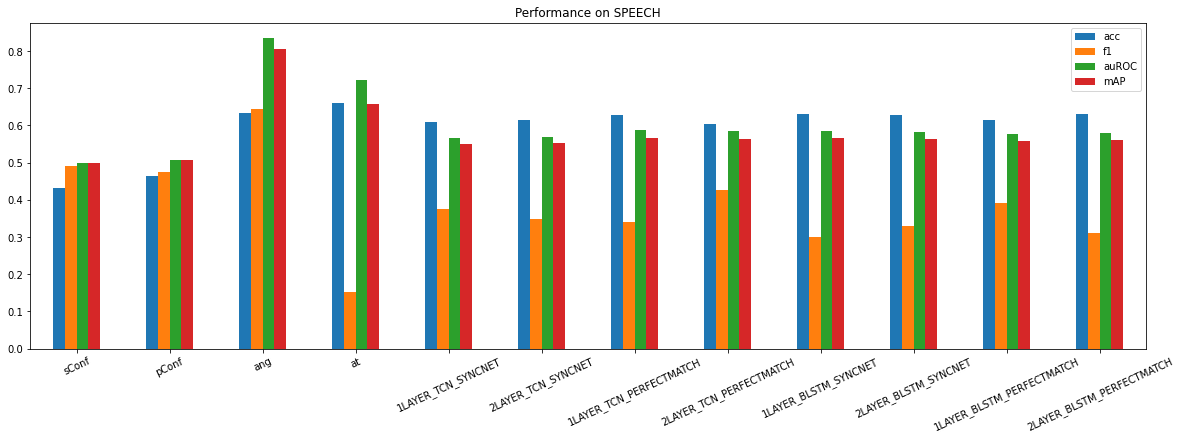

In [86]:
s = score_df(full_df, label="SPEECH",print_df=True,plot=True)


          sConf     pConf       ang        at  1LAYER_TCN_SYNCNET  \
acc    0.431746  0.462914  0.620850  0.657909            0.630711   
f1     0.491598  0.475331  0.632934  0.149218            0.324658   
auROC  0.499560  0.508168  0.810900  0.708847            0.581115   
mAP    0.499836  0.505886  0.780821  0.645379            0.563265   

       2LAYER_TCN_SYNCNET  1LAYER_TCN_PERFECTMATCH  2LAYER_TCN_PERFECTMATCH  \
acc              0.622895                 0.626479                 0.622227   
f1               0.324262                 0.359094                 0.386967   
auROC            0.566020                 0.585684                 0.585664   
mAP              0.553094                 0.567483                 0.565515   

       1LAYER_BLSTM_SYNCNET  2LAYER_BLSTM_SYNCNET  1LAYER_BLSTM_PERFECTMATCH  \
acc                0.622997              0.621481                   0.628380   
f1                 0.334442              0.346588                   0.337945   
auROC             

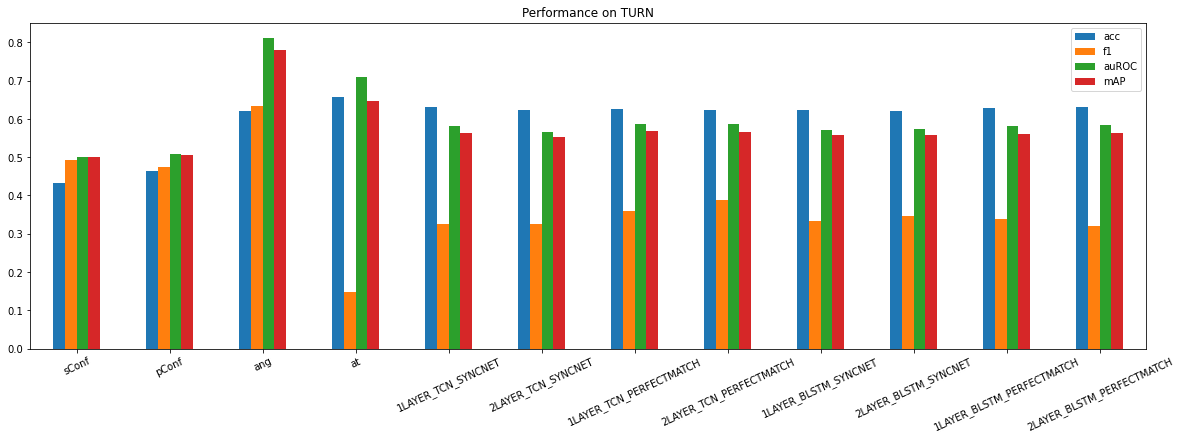

In [15]:
s = score_df(full_df, label="TURN",print_df=True,plot=True)


## Score models performance for different head rotations

In [25]:
def calc_perf_by(df, windows, split_col_name, plot=False, label="SPEECH"):
    results = []
    ticks = []
    
    #window = (max(df[split_col_name]) - min(df[split_col_name]))/num_windows

    for rmin, rmax in windows:
        #rmin = min(df[split_col_name]) + window * i
        #rmax = min(df[split_col_name]) + window * (i+1)
        sub_df = df[(df[split_col_name]>=rmin*math.pi/180) & (df[split_col_name]<rmax*math.pi/180)]

        tick = f"{rmin:.0f}:{rmax:.0f}"

#         print(f"Range is {rmin:.0f}, {rmax:.0f} and support is {len(sub_df)}")
        s = score_df(sub_df, label=label, print_df=False, plot=plot)
        results.append(s)
        ticks.append(tick)
    return results,ticks

['-60:-20', '-20:20', '20:60']


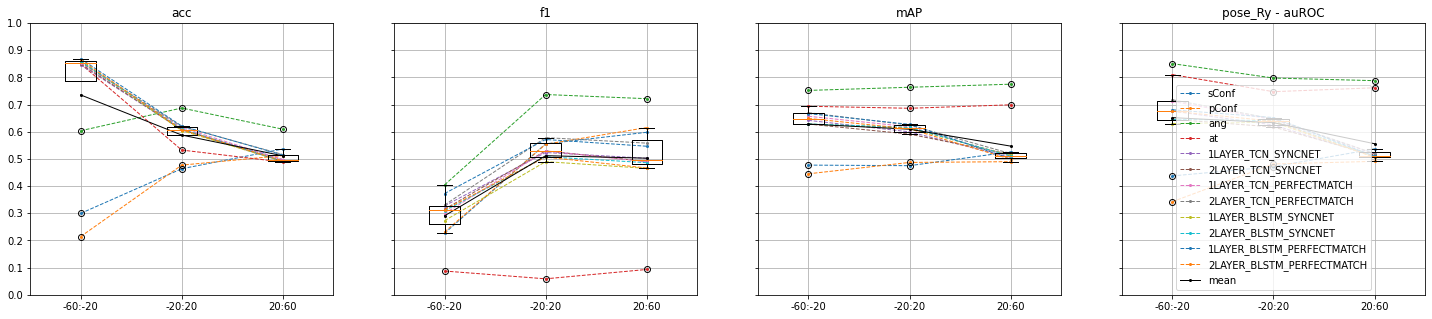

In [27]:
buckets = [(-60,-20),(-20,20),(20,60)]
small_results,ticks = calc_perf_by(full_df[:100000], buckets, "pose_Ry", label="SPEECH")
# print(ticks)
originals = list(small_results[0].keys())[:2]
gaze = list(small_results[0].keys())[2:4]
new = list(small_results[0].keys())[4:]
# display_perf_by(small_results, "pose_Ry", ticks, originals+gaze+new)

In [24]:
def avg_gaze(full_df, gaze_type="ang", weights=[1,1]):
    df = full_df.copy(deep=True)
    for c in df.columns:
        if c not in ["pose_Rx","pose_Ry", f"SPEECH-LABEL","TURN-LABEL","p1_ang","p2_ang","p1_at","p2_at","ang_mult","at_mult"]:
            df[c] = (df[c].values * weights[0] + df[f"{gaze_type}_mult"] * weights[1])/ sum(weights)
    return df

def mult_gaze(full_df, gaze_type="ang", weights=[1,1]):
    df = full_df.copy(deep=True)
    for c in df.columns:
        if c not in ["pose_Rx","pose_Ry", f"SPEECH-LABEL","TURN-LABEL","p1_ang","p2_ang","p1_at","p2_at","ang_mult","at_mult"]:
            df[c] = df[c].values * (df[f"{gaze_type}_mult"] + .5)
    return df

In [87]:
def get_multiplied_conf(full_df):
    dfs = {}

    for gaze_type in ["ang","at"]:
        dfs[gaze_type] = {}
        dfs[gaze_type]["avg"] = avg_gaze(full_df, gaze_type=gaze_type, weights=[1,5])
        dfs[gaze_type]["mult"] = mult_gaze(full_df, gaze_type=gaze_type)
    return dfs

def get_all_results(dfs):
    results = {}

    for num_buckets in [3,4,5,6,10]:
        bucket_size = 120/num_buckets
        buckets = [(-60+i*bucket_size, -60+(i+1)*bucket_size) for i in range(num_buckets)]
        results[num_buckets]={}
        for label in ["SPEECH","TURN"]:
            results[num_buckets][label]={}
            results[num_buckets][label]["original"],_=calc_perf_by(full_df, buckets, "pose_Ry", label=label)

            for gaze_type, mult_type_dfs in dfs.items():
                results[num_buckets][label][gaze_type]={}

                for mult_type, df in mult_type_dfs.items():
                    print(num_buckets, label, gaze_type, mult_type)
                    results[num_buckets][label][gaze_type][mult_type], ticks = calc_perf_by(df, buckets, "pose_Ry", label=label)
                    results[num_buckets]["xticks"]=ticks
    return results

dfs = get_multiplied_conf(full_df)
results = get_all_results(dfs)
        

3 SPEECH ang avg
3 SPEECH ang mult
3 SPEECH at avg
3 SPEECH at mult
3 TURN ang avg
3 TURN ang mult
3 TURN at avg
3 TURN at mult
4 SPEECH ang avg
4 SPEECH ang mult
4 SPEECH at avg
4 SPEECH at mult
4 TURN ang avg
4 TURN ang mult
4 TURN at avg
4 TURN at mult
5 SPEECH ang avg
5 SPEECH ang mult
5 SPEECH at avg
5 SPEECH at mult
5 TURN ang avg
5 TURN ang mult
5 TURN at avg
5 TURN at mult
6 SPEECH ang avg
6 SPEECH ang mult
6 SPEECH at avg
6 SPEECH at mult
6 TURN ang avg
6 TURN ang mult
6 TURN at avg
6 TURN at mult
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance i

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one c

/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

# Visualizing Performance

## Performance

In [101]:
def plot_perf_on_axis(ax, models, metric, r, ticks, title, ylabel, xlabel):
    for m in models:

        y = [a[m][metric] for a in r]
        x = list(range(len(y)))
        ax.plot(x, y, linestyle='dashed', linewidth=2,label=m)            

    data = [[a[m][metric] for m in models] for a in r]
#     ax.boxplot(data, positions = range(len(ticks)))
    ax.plot(x, [sum(row)/len(row) for row in data], marker='o', linestyle='solid', linewidth=1, markersize=2,label="mean",color="black")


    ax.set_title(title)
    ax.grid(True)

    ax.set_yticks(ticks = [.25,.5,.75,1])
    ax.set_ylabel(ylabel)

    new_ticks = [f"[{t}]" for t in ticks]
    ax.set_xticks(ticks=[i for i in range(len(x))])
    ax.set_xticklabels(new_ticks)
    ax.set_xlabel(xlabel)
    ax.legend(prop={'size': 6})

def display_perf_by(results, ticks, models,title='Metric Performance'):
    
    r = results
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False,figsize=(25, 5))
    for i, metric in enumerate(["acc","f1","mAP", "auROC"]):
        plot_perf_on_axis(axs[i], models, metric, r, ticks, title, f'{metric} Scores', 'Head Rotation (degrees)')

        
    fig.suptitle(title,y=0.98, fontsize=16)
    plt.show()
    
def create_paper_perf_figure(results, num_buckets=4, metric="mAP", title='Metric Performance'):
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False,figsize=(25, 5))
    ticks = results[num_buckets]["xticks"]

    label="SPEECH"
    r = results[num_buckets][label]["original"]
    plot_perf_on_axis(axs[0], originals, metric, r, ticks, "Synthesizers Speech Performance", f'{metric} Scores', 'Head Rotation (degrees)')
    plot_perf_on_axis(axs[1], new, metric, r, ticks, "Fine-Tuned Speech Performance", f'{metric} Scores', 'Head Rotation (degrees)')
    
    label="TURN"
    r = results[num_buckets][label]["original"]
    plot_perf_on_axis(axs[2], originals, metric, r, ticks, "Synthesizers Turn Performance", f'{metric} Scores', 'Head Rotation (degrees)')
    plot_perf_on_axis(axs[3], new, metric, r, ticks, "Fine-Tuned Speech Performance", f'{metric} Scores', 'Head Rotation (degrees)')

    fig.suptitle(title,y=0.98, fontsize=16)
    plt.savefig(f"{title}.png")
    plt.show()

## Improvement

In [102]:
def plot_imprv_on_axis(ax, models, metric, r0, r1, ticks, title, ylabel, xlabel):
    ys = []
    for m in models:
        y0 = [a[m][metric] for a in r0]
        y1 = [a[m][metric] for a in r1]
        y=[y1[k]-y0[k] for k in range(len(y0))]
        ys.append(y)

        x = list(range(len(y)))
        ax.plot(x, y, marker='o', linestyle='dashed', linewidth=2, markersize=2,label=m)            

    data = [list(x) for x in zip(*ys)]
#     ax.boxplot(data, positions = range(len(ticks)))
    ax.plot(x, [sum(row)/len(row) for row in data], marker='o', linestyle='solid', linewidth=1, markersize=2,label="mean",color="black")
#     ax.plot(x, [0 for i in range(len(y))],color="black")

    ax.set_title(title)
    ax.grid(True)

    ax.set_yticks(ticks = [-.1,0,.1,.2,.3])
    ax.set_ylabel(ylabel)
    new_ticks = [f"[{t}]" for t in ticks]
    ax.set_xticks(ticks=[i for i in range(len(x))])
    ax.set_xticklabels(new_ticks)
    ax.set_xlabel(xlabel)
    ax.legend(prop={'size': 6})

def display_improv_by(results,new_results, ticks, models,title='Metric Improvement'):
    
    r0 = results
    r1 = new_results
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False,figsize=(25, 5))
    for i, metric in enumerate(["acc","f1","mAP", "auROC"]):
        plot_imprv_on_axis(axs[i], models, metric, r0, r1, ticks, f"Improvement ({metric}) vs Head Rotation", f'{metric} Improv. Scores', 'Head Rotation (degrees)')
        
    fig.suptitle(title, fontsize=16)
    plt.show()
    
def display_improv_metric(results, models, num_buckets=5,label="SPEECH",metric="mAP", title='Metric Improvement by Gaze and Combination Type'):
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False,figsize=(30, 8))
    i = 0
    for gaze_type in ["at","ang"]:
        for mult_type in ["mult", "avg"]:
            r0 = results[num_buckets][label]["original"]
            r1 = results[num_buckets][label][gaze_type][mult_type]
            ticks = results[num_buckets]["xticks"]
            
            plot_imprv_on_axis(axs[i], models, metric, r0, r1, ticks, f"Improvement ({metric}) vs Head Rotation", f'{metric} Improv. Scores', 'Head Rotation (degrees)')
            i+=1
            
        
    fig.suptitle(title, fontsize=16)
    plt.show()
    

def create_paper_imprv_figure(results, gaze_type="ang", mult_type="avg", num_buckets=4, metric="mAP", title='Metric Performance'):
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False,figsize=(25, 5))
    ticks = results[num_buckets]["xticks"]
    print(ticks)

    label="SPEECH"
    r0 = results[num_buckets][label]["original"]
    r1 = results[num_buckets][label][gaze_type][mult_type]
    plot_imprv_on_axis(axs[0], originals, metric, r0, r1, ticks, "Synthesizers Speech Improvement", f'{metric} Improv. Scores', 'Head Rotation (degrees)')
    plot_imprv_on_axis(axs[1], new, metric, r0, r1, ticks, "Fine-Tuned Speech Improvement", f'{metric} Improv. Scores', 'Head Rotation (degrees)')
    
    label="TURN"
    r0 = results[num_buckets][label]["original"]
    r1 = results[num_buckets][label][gaze_type][mult_type]
    plot_imprv_on_axis(axs[2], originals, metric, r0, r1, ticks, "Synthesizers Turn Improvement", f'{metric} Improv. Scores', 'Head Rotation (degrees)')
    plot_imprv_on_axis(axs[3], new, metric, r0, r1, ticks, "Fine-Tuned Turn Improvement", f'{metric} Improv. Scores', 'Head Rotation (degrees)')

    fig.suptitle(title,y=0.98, fontsize=16)
    plt.savefig(f"{title}.png")
    
    plt.show()

# Error/Performance Analysis

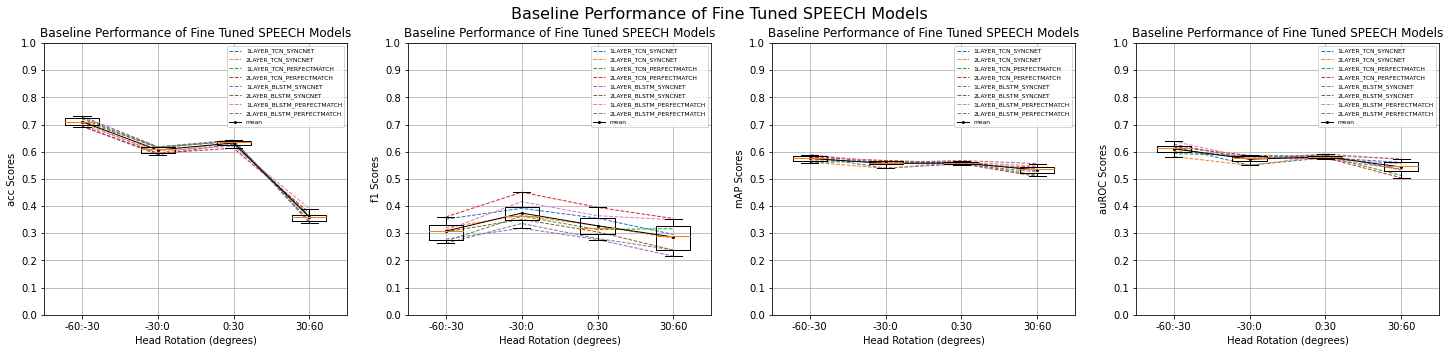

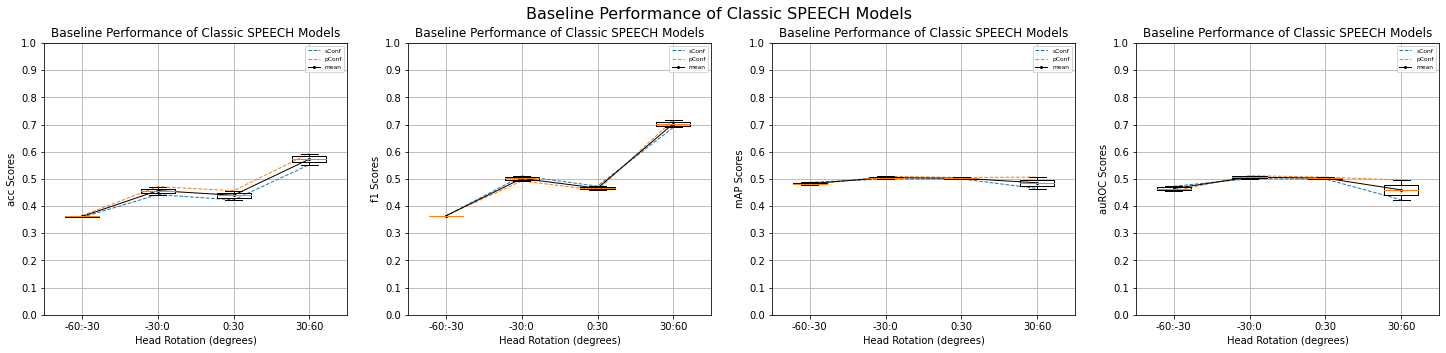

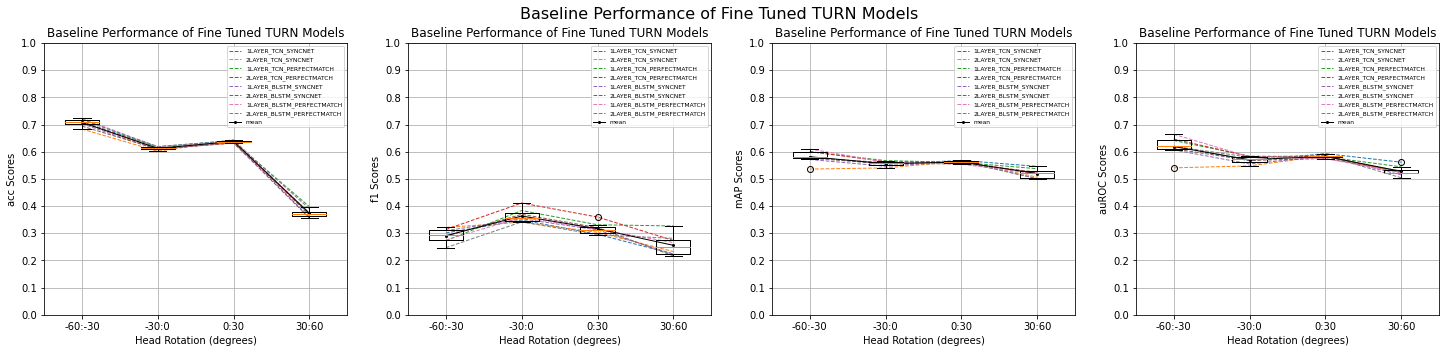

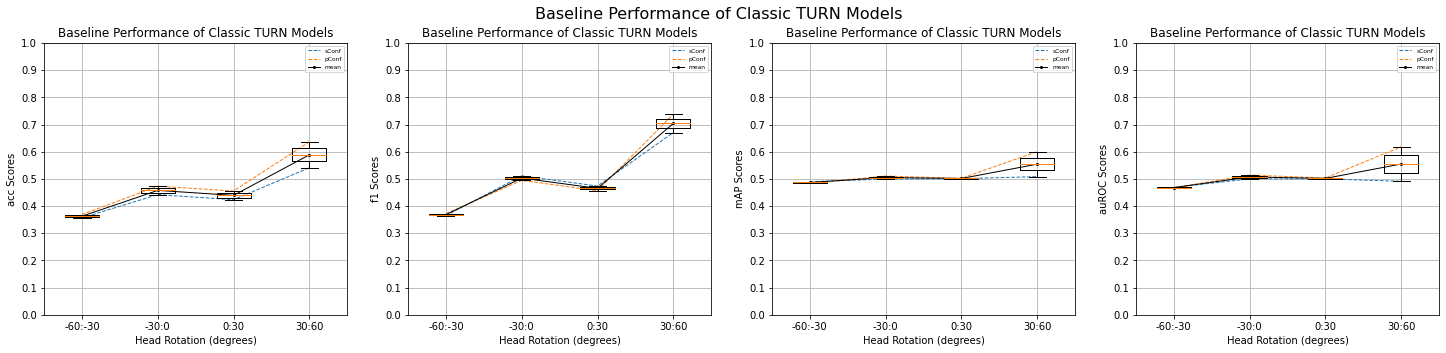

In [63]:
num_buckets=4
label="SPEECH"
# gaze_type="ang"
# mult_type="mult"

r0 = results[num_buckets][label]["original"]
r = results[num_buckets][label][gaze_type][mult_type]
ticks = results[num_buckets]["xticks"]


display_perf_by(r0, ticks, new, title=f"Baseline Performance of Fine Tuned {label} Models")
# display_perf_by(r, ticks, new, title=f"Modified Performance of Fine Tuned {label} Models ({gaze_type}-{mult_type})")
# display_improv_by(r0, r, ticks, new, title=f"Improvement of Fine Tuned {label} Models ({gaze_type}-{mult_type})")

display_perf_by(r0, ticks, originals, title=f"Baseline Performance of Classic {label} Models")
# display_perf_by(r, ticks, originals, title=f"Modified Performance of Classic {label} Models ({gaze_type}-{mult_type})")
# display_improv_by(r0, r, ticks, originals, title=f"Improvement of Classic {label} Models ({gaze_type}-{mult_type})")

label="TURN"
# gaze_type="ang"
# mult_type="mult"

r0 = results[num_buckets][label]["original"]
r = results[num_buckets][label][gaze_type][mult_type]
ticks = results[num_buckets]["xticks"]


display_perf_by(r0, ticks, new, title=f"Baseline Performance of Fine Tuned {label} Models")
# display_perf_by(r, ticks, new, title=f"Modified Performance of Fine Tuned {label} Models ({gaze_type}-{mult_type})")
# display_improv_by(r0, r, ticks, new, title=f"Improvement of Fine Tuned {label} Models ({gaze_type}-{mult_type})")

display_perf_by(r0, ticks, originals, title=f"Baseline Performance of Classic {label} Models")
# display_perf_by(r, ticks, originals, title=f"Modified Performance of Classic {label} Models ({gaze_type}-{mult_type})")
# display_improv_by(r0, r, ticks, originals, title=f"Improvement of Classic {label} Models ({gaze_type}-{mult_type})")

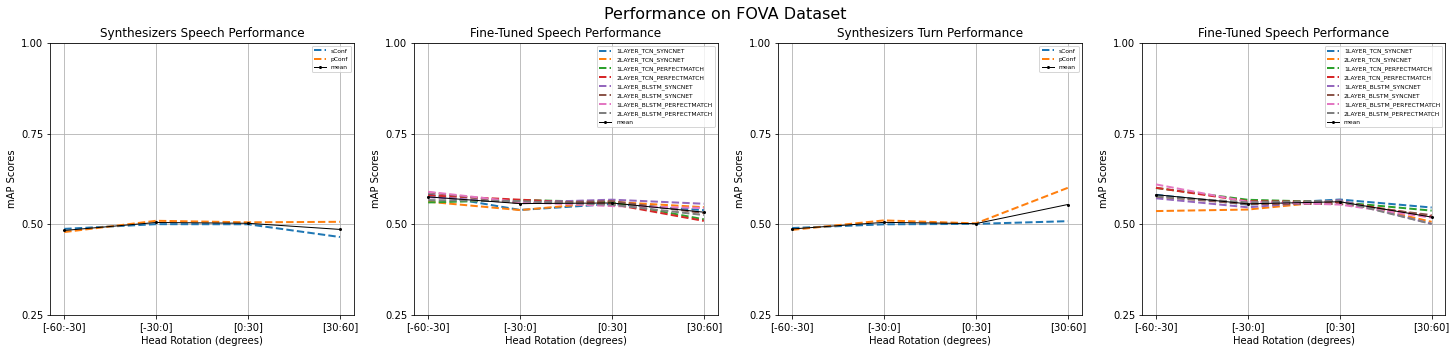

In [103]:
create_paper_perf_figure(kalins_results, num_buckets=4, metric="mAP", title='Performance on FOVA Dataset')

# Improvement with Modification

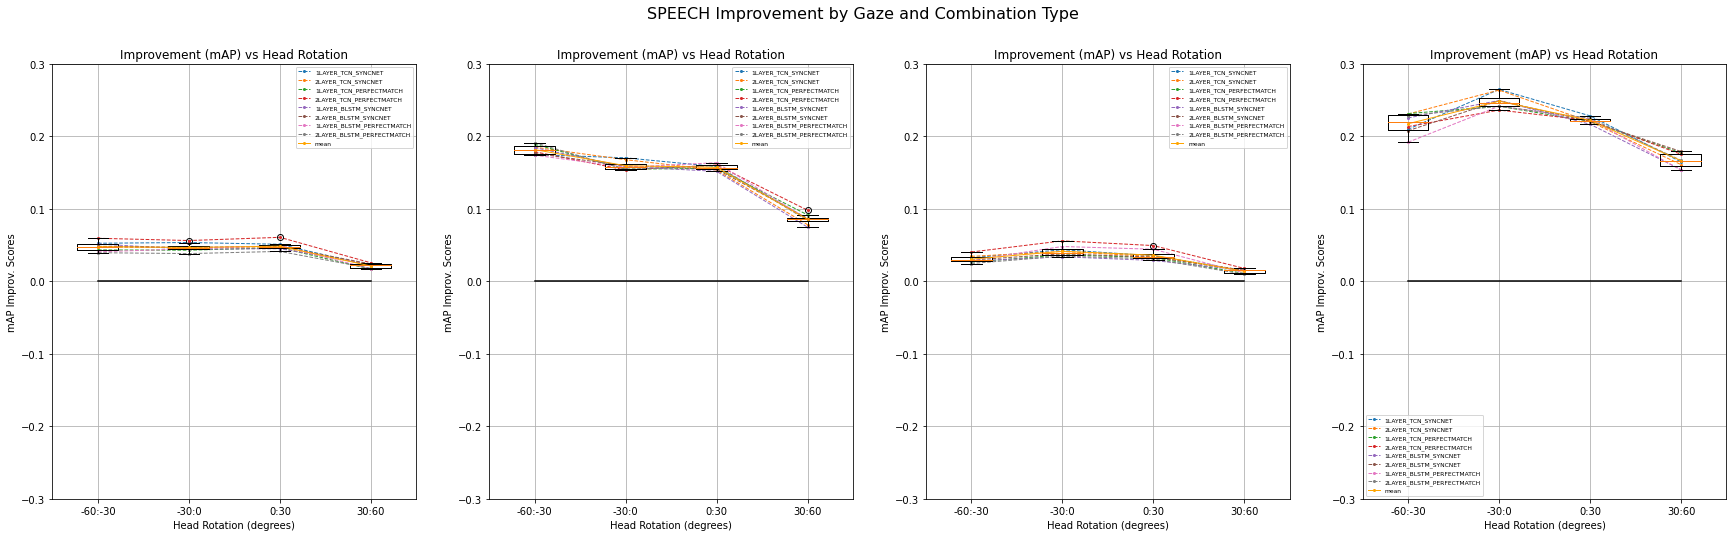

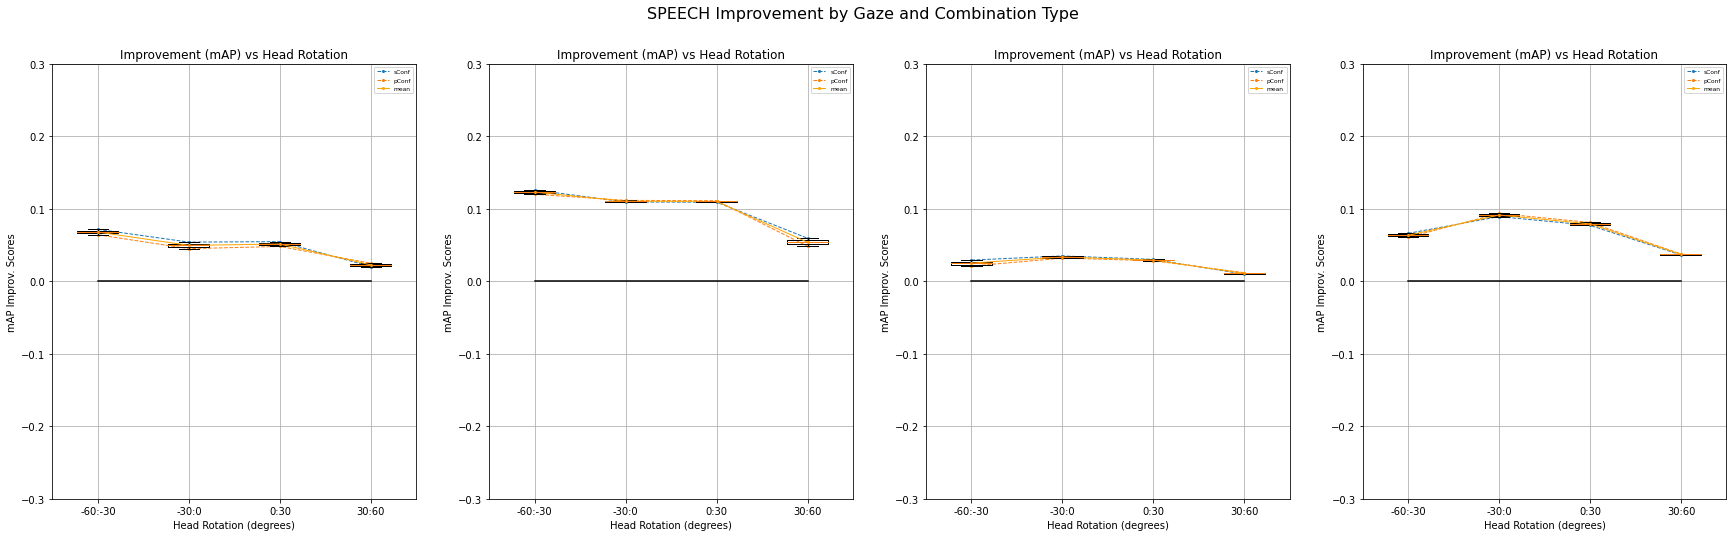

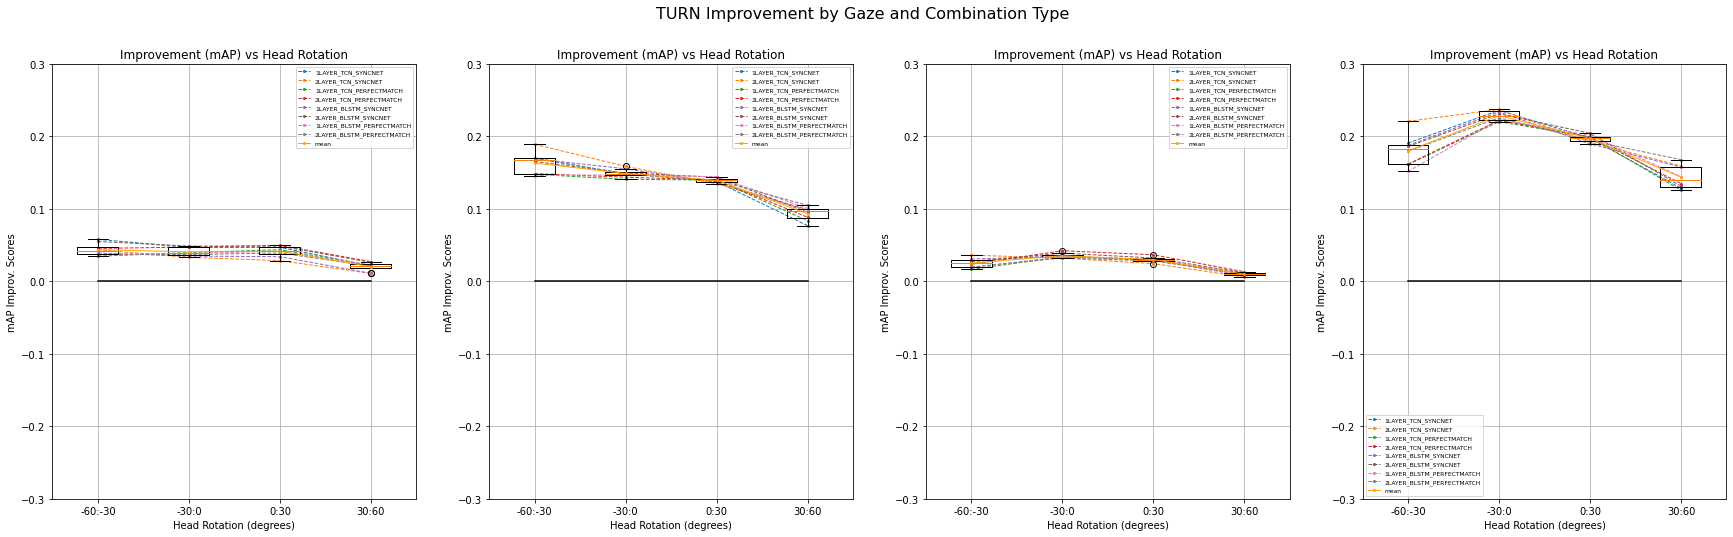

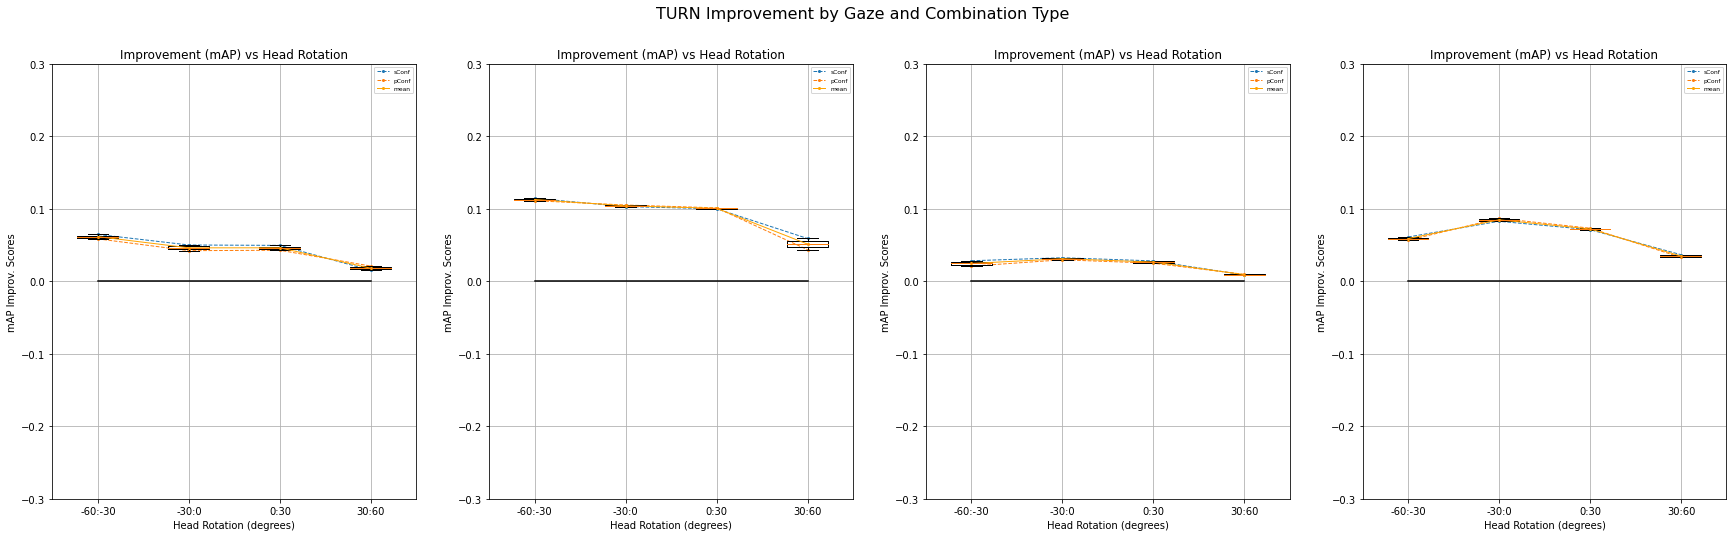

In [74]:
auROC = "mAP"

display_improv_metric(results, new, num_buckets=num_buckets,label="SPEECH",metric=metric, title='SPEECH Improvement by Gaze and Combination Type')
display_improv_metric(results, originals, num_buckets=num_buckets,label="SPEECH",metric=metric, title='SPEECH Improvement by Gaze and Combination Type')

display_improv_metric(results, new, num_buckets=num_buckets,label="TURN",metric=metric, title='TURN Improvement by Gaze and Combination Type')
display_improv_metric(results, originals, num_buckets=num_buckets,label="TURN",metric=metric, title='TURN Improvement by Gaze and Combination Type')

['-60:-30', '-30:0', '0:30', '30:60']


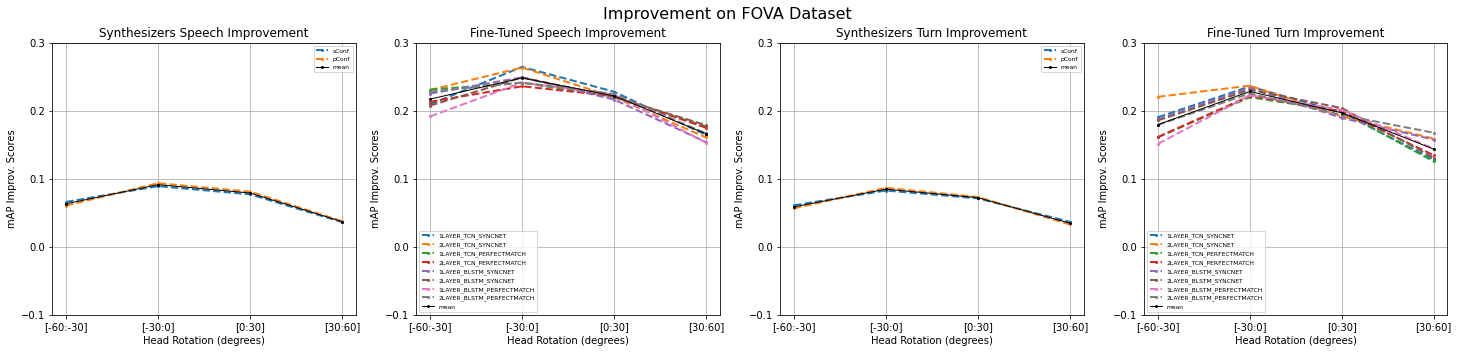

In [98]:
create_paper_imprv_figure(results, gaze_type="ang", mult_type="avg", num_buckets=4, metric="mAP", title='Improvement on FOVA Dataset')


5 SPEECH ang mult
Original:


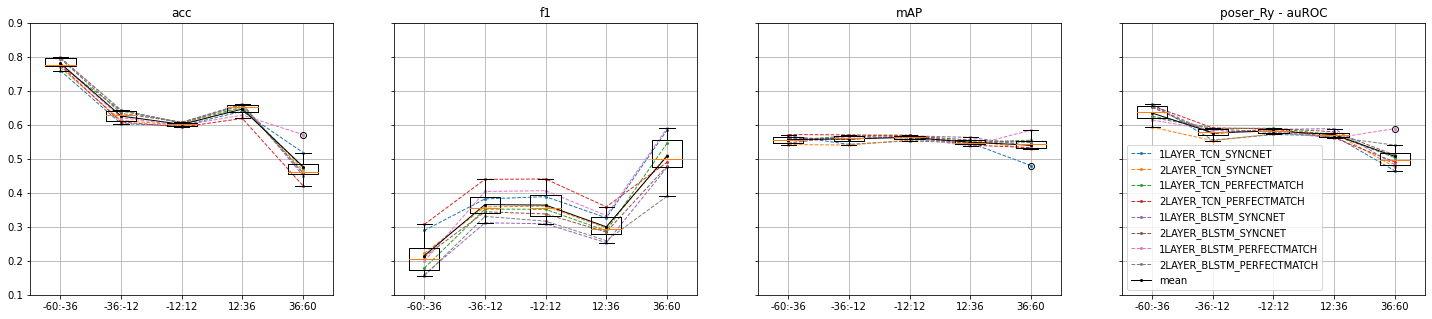

After:


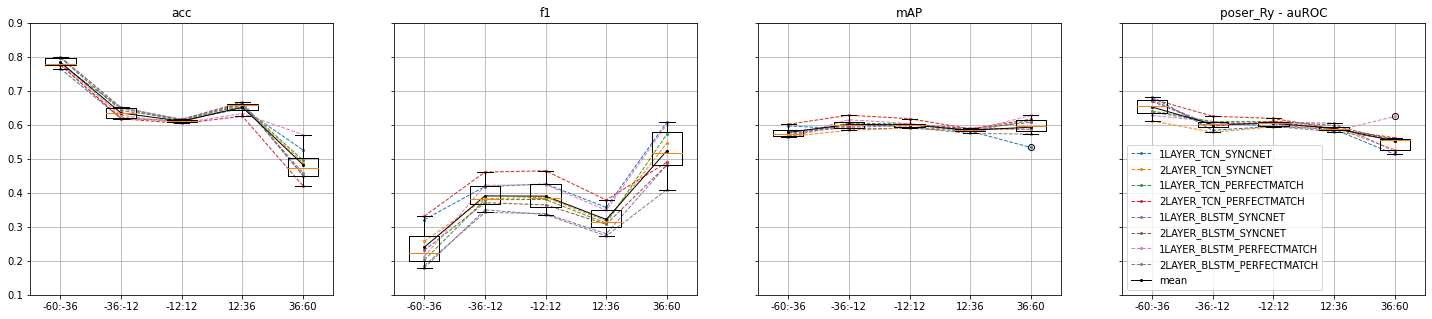

Improvement:


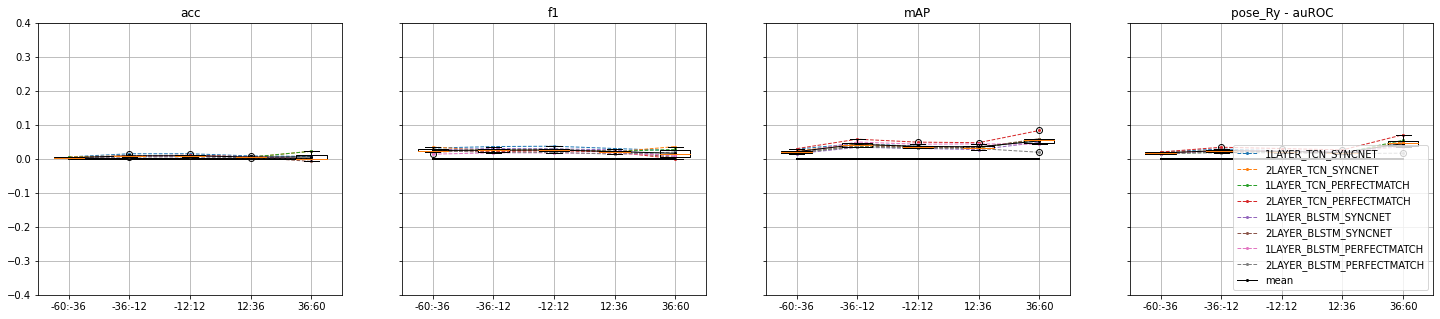

Original:


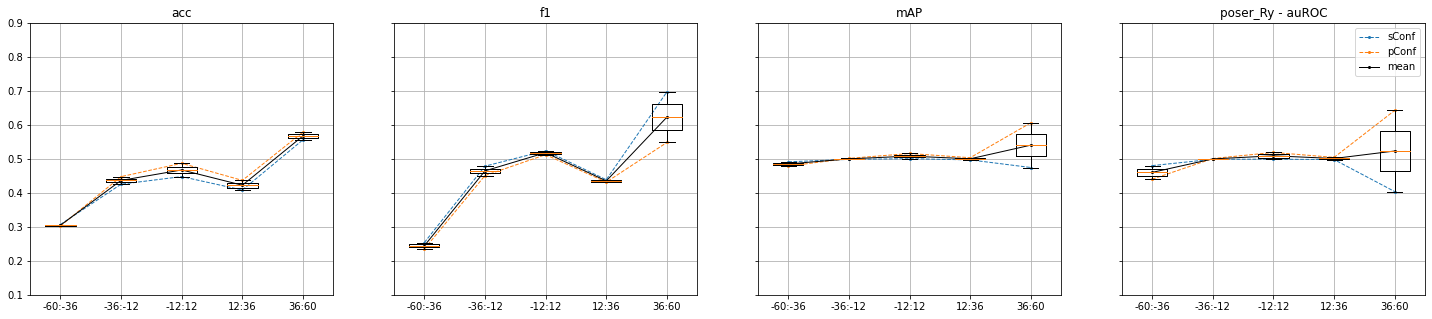

After:


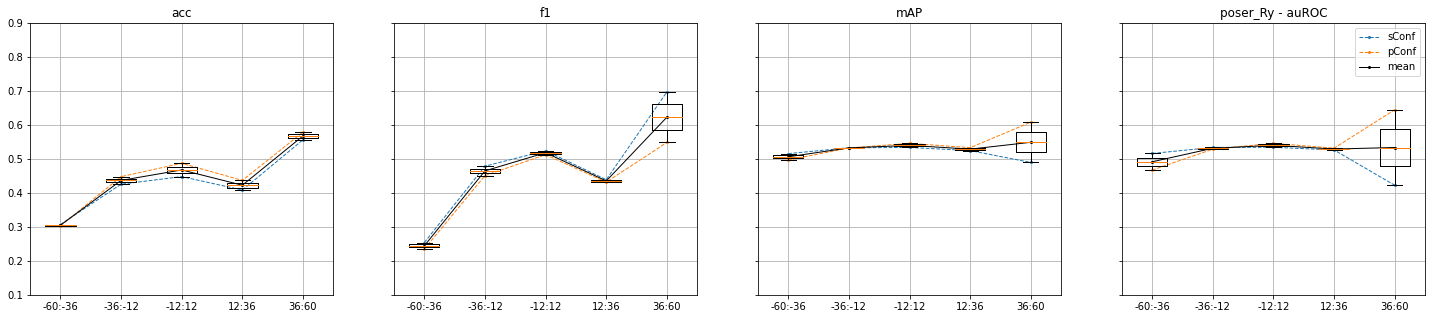

Improvement:


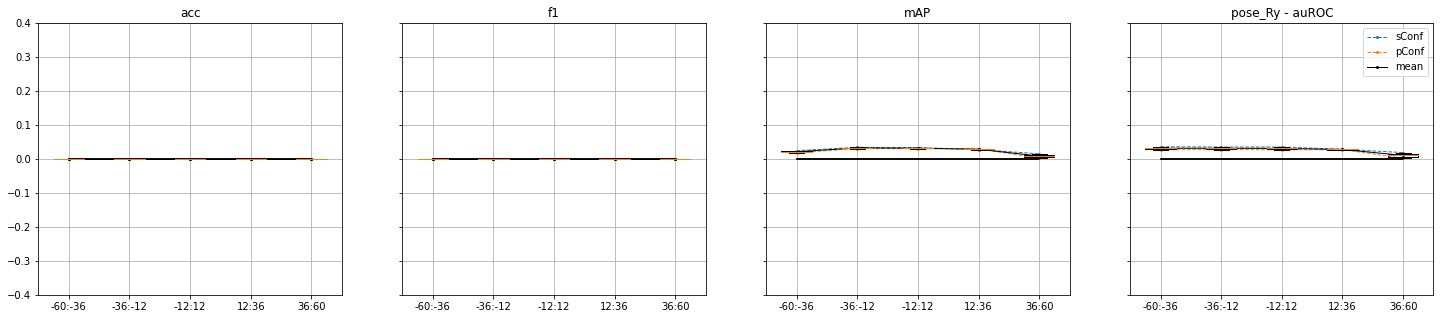

In [36]:
num_buckets=5
label="SPEECH"
gaze_type="ang"
mult_type="mult"

r0 = results[num_buckets][label]["original"]
r = results[num_buckets][label][gaze_type][mult_type]
ticks = results[num_buckets]["xticks"]

print(num_buckets, label, gaze_type, mult_type)
print("Original:")
display_perf_by(r0, "poser_Ry", ticks, new)
print("After:")
display_perf_by(r, "poser_Ry", ticks, new)
print("Improvement:")
display_perf_by_change(r0, r, "pose_Ry", ticks, new)

print("Original:")
display_perf_by(r0, "poser_Ry", ticks, originals)
print("After:")
display_perf_by(r, "poser_Ry", ticks, originals)
print("Improvement:")
display_perf_by_change(r0, r, "pose_Ry", ticks, originals)

3 SPEECH ang mult
Improvement:


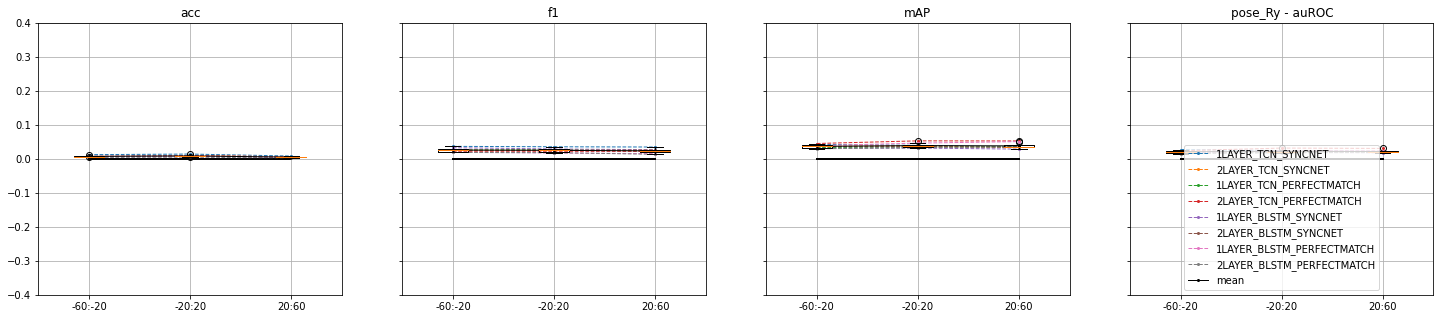

Improvement:


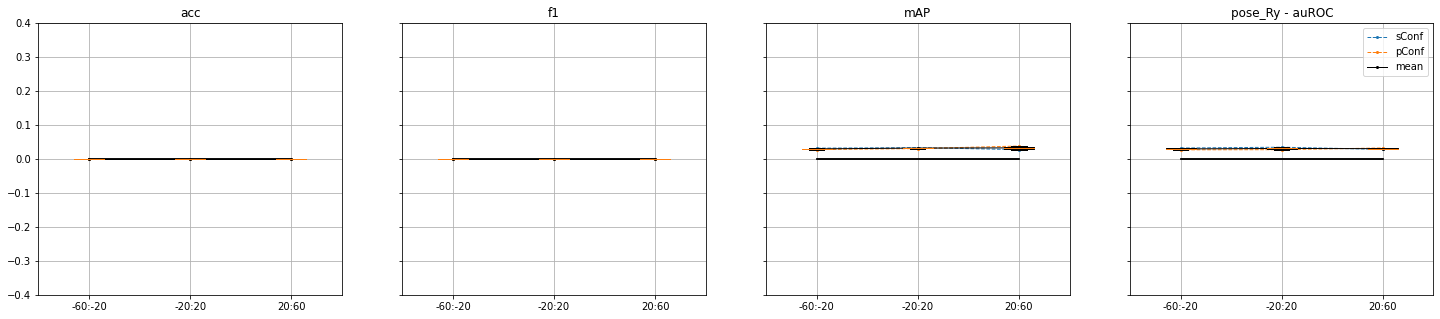

3 SPEECH ang avg
Improvement:


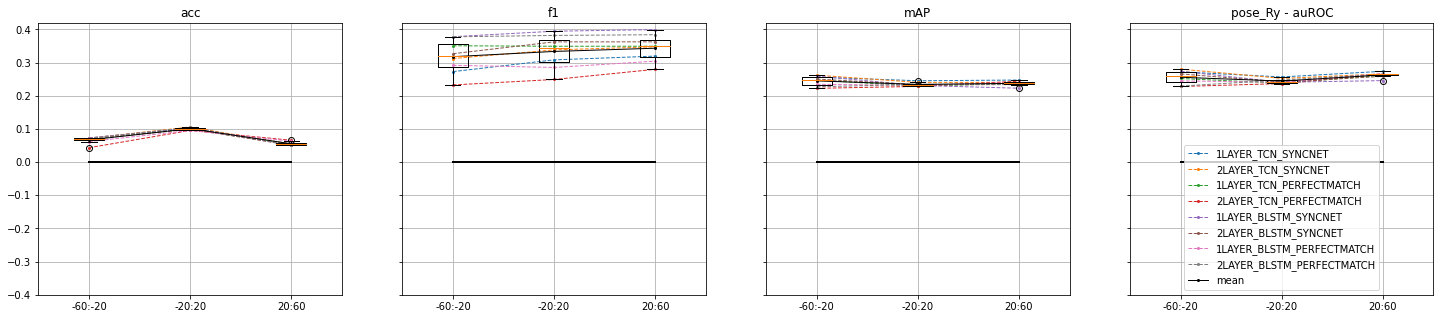

Improvement:


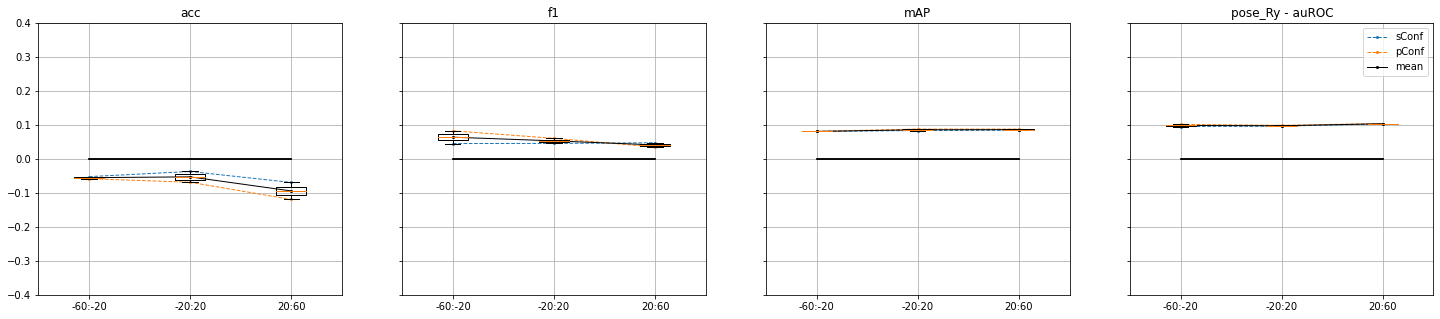

3 SPEECH at mult
Improvement:


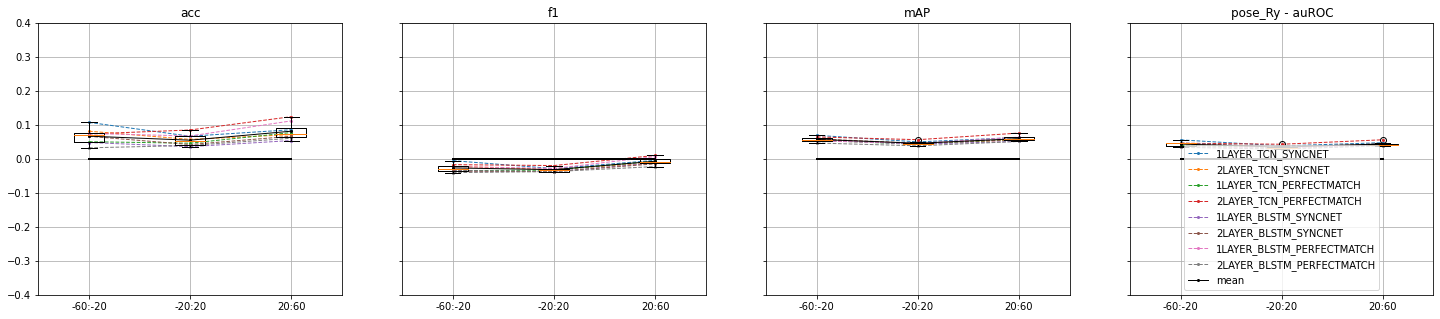

Improvement:


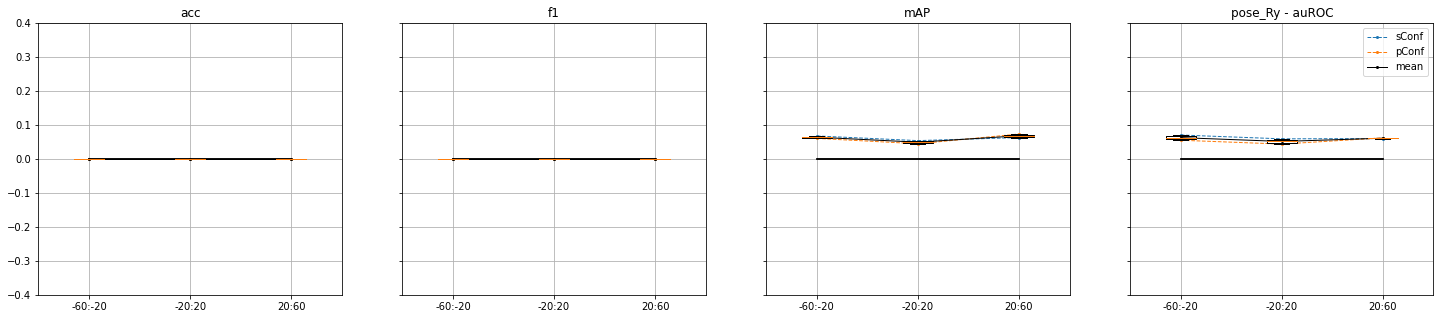

3 SPEECH at avg
Improvement:


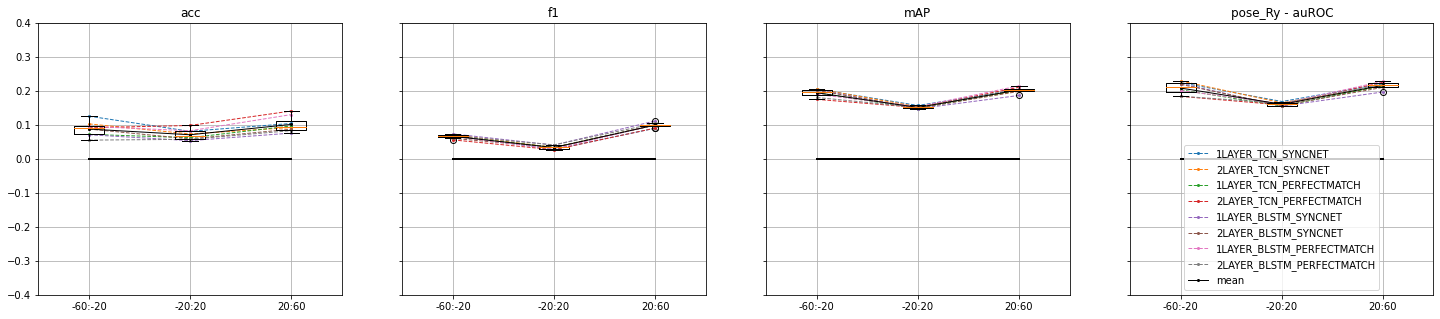

Improvement:


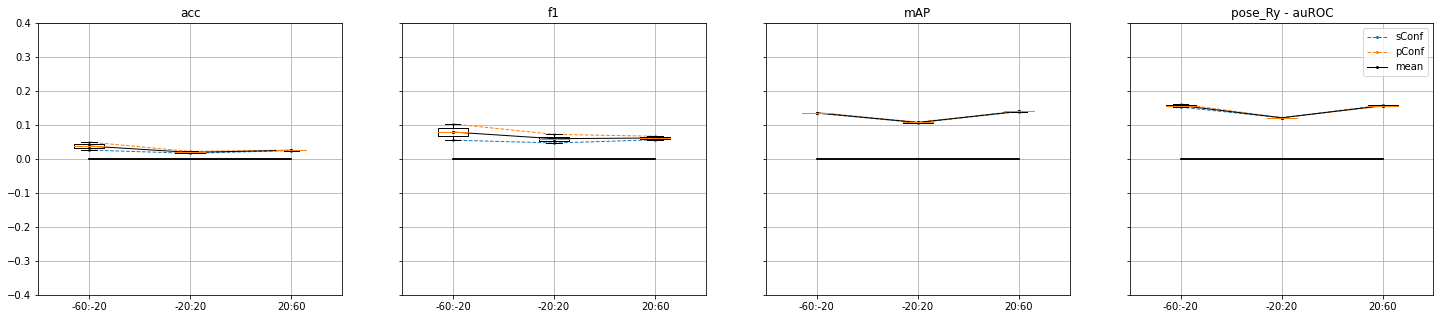

3 TURN ang mult
Improvement:


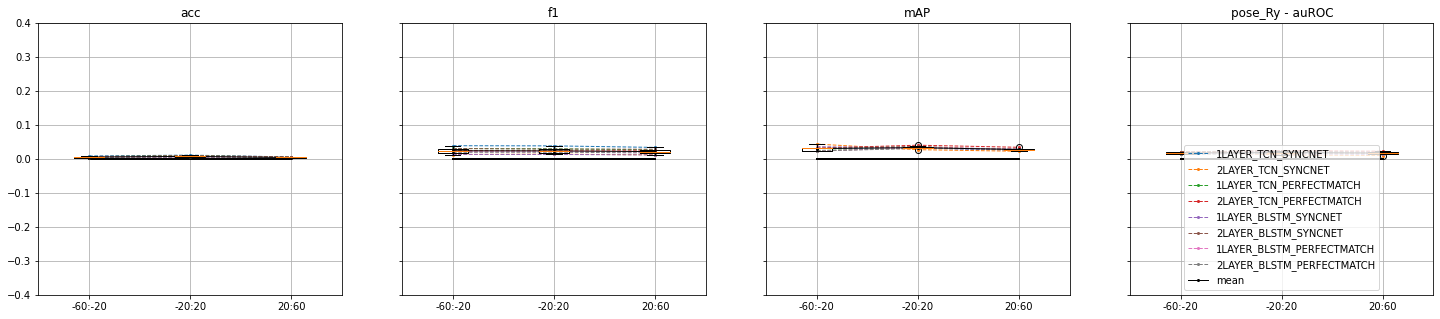

Improvement:


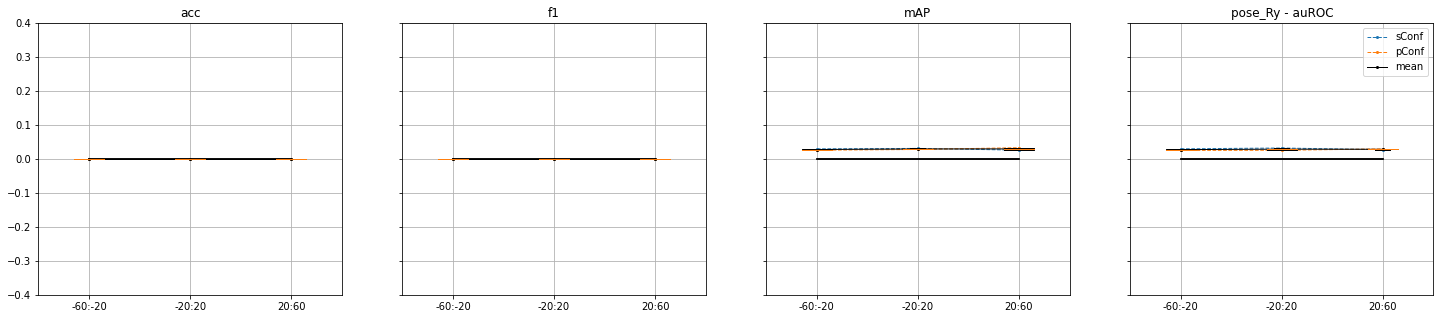

3 TURN ang avg
Improvement:


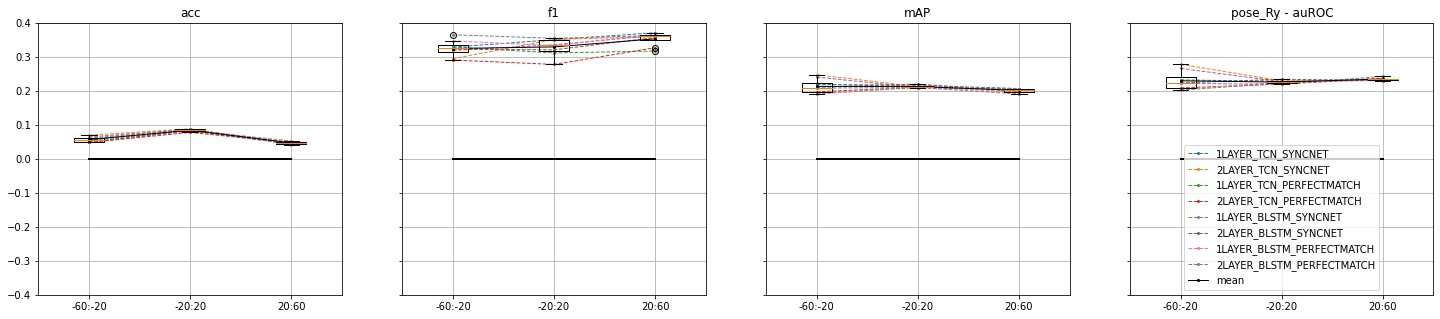

Improvement:


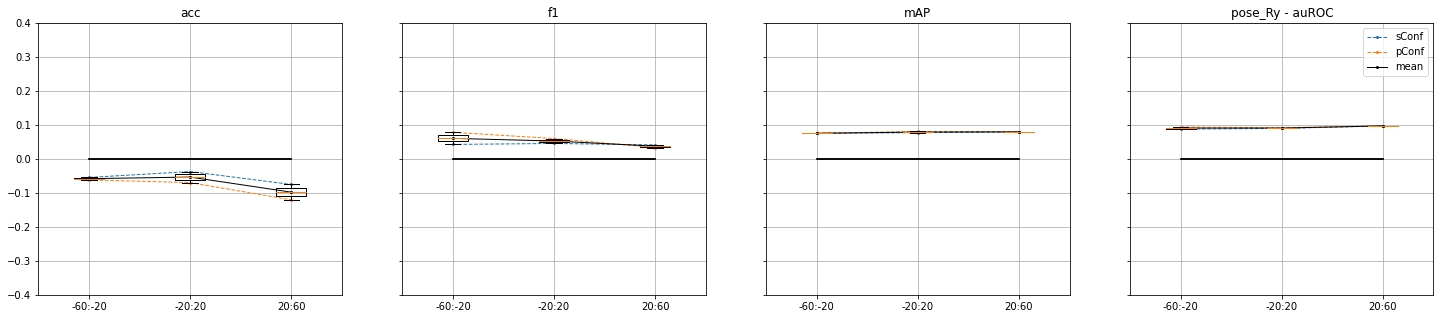

3 TURN at mult
Improvement:


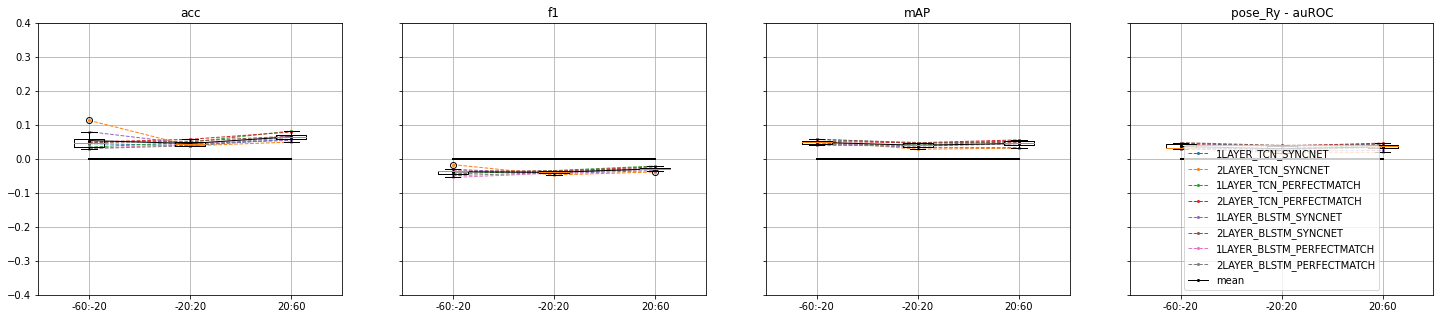

Improvement:


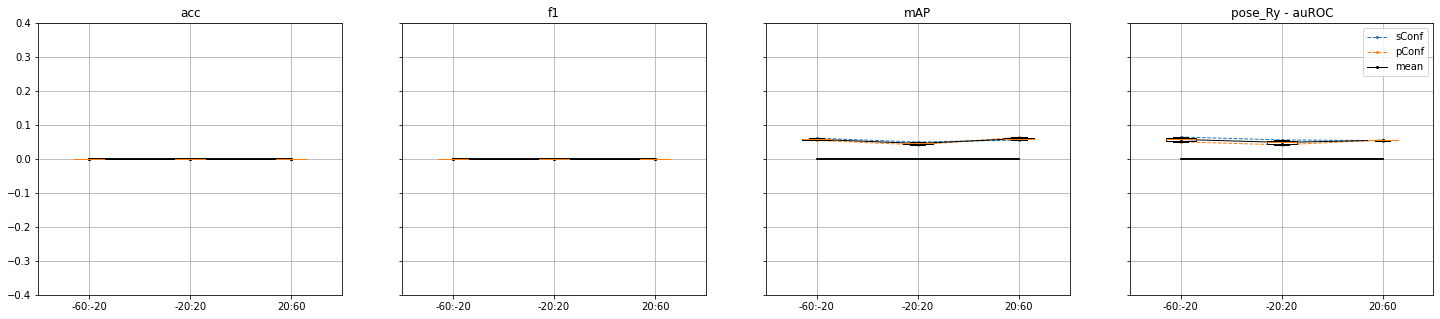

3 TURN at avg
Improvement:


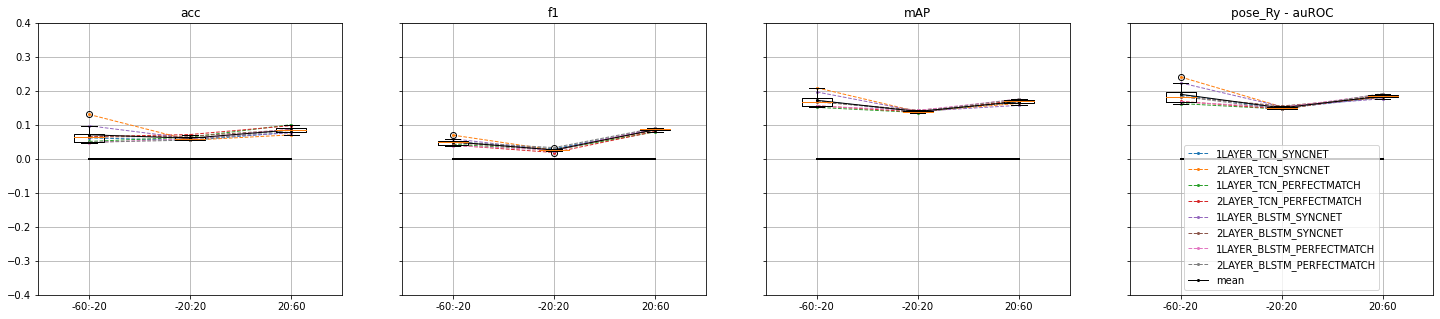

Improvement:


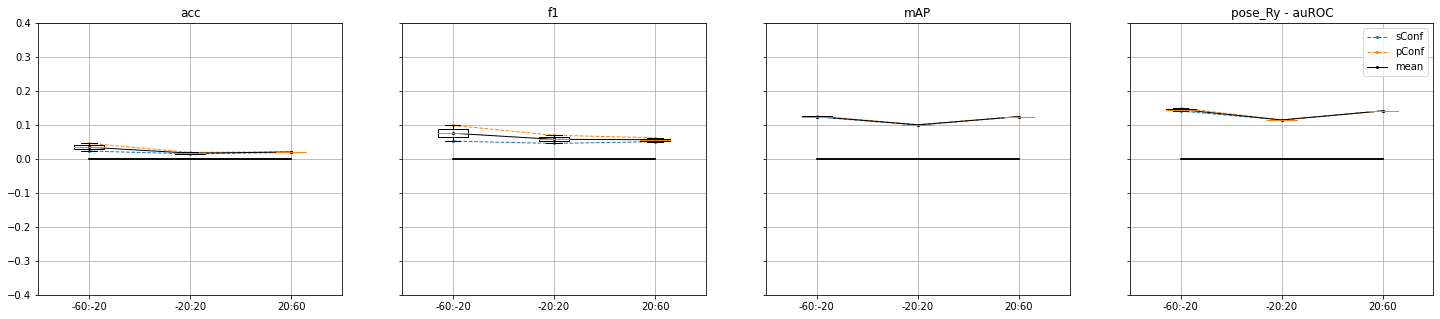

In [38]:
num_buckets=3

for label in ["SPEECH","TURN"]:
    for gaze_type in ["ang","at"]:
        for mult_type in ["mult", "avg"]:

            r0 = results[num_buckets][label]["original"]
            r = results[num_buckets][label][gaze_type][mult_type]
            ticks = results[num_buckets]["xticks"]

            print(num_buckets, label, gaze_type, mult_type)
            # print("Original:")
            # display_perf_by(r0, "poser_Ry", ticks, new)
            # print("After:")
            # display_perf_by(r, "poser_Ry", ticks, new)
            print("Improvement:")
            display_perf_by_change(r0, r, "pose_Ry", ticks, new)

            # print("Original:")
            # display_perf_by(r0, "poser_Ry", ticks, originals)
            # print("After:")
            # display_perf_by(r, "poser_Ry", ticks, originals)
            print("Improvement:")
            display_perf_by_change(r0, r, "pose_Ry", ticks, originals)

# Examine Turn Performance

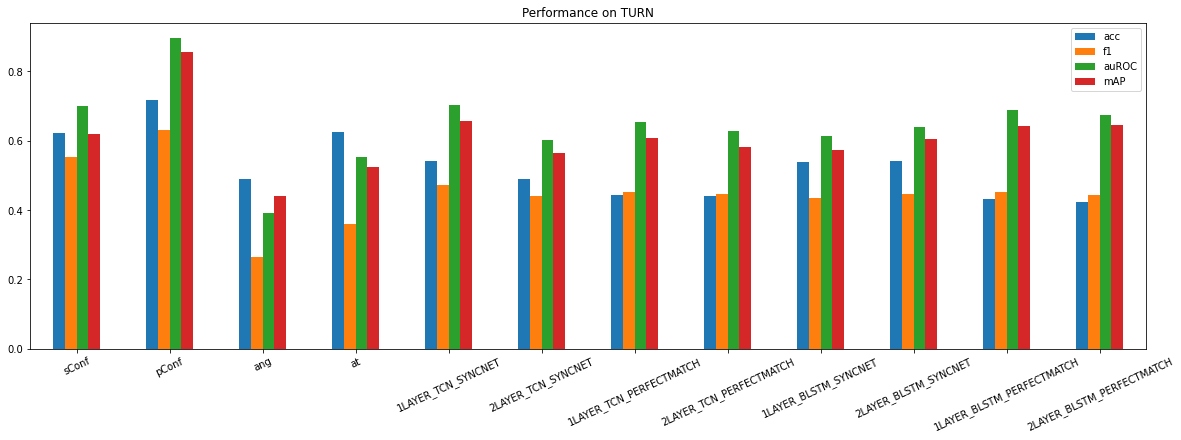

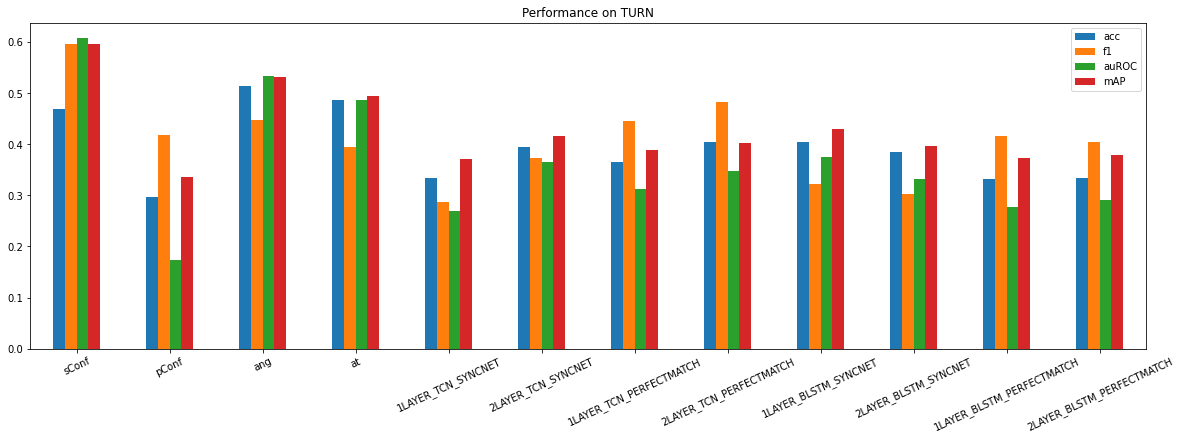

In [10]:
s = score_df(full_df, label="TURN",print_df=False,plot=True)
s = score_df(full_df[full_df[f"SPEECH-LABEL"] != full_df[f"TURN-LABEL"]], label="TURN",print_df=False,plot=True)

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 1.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


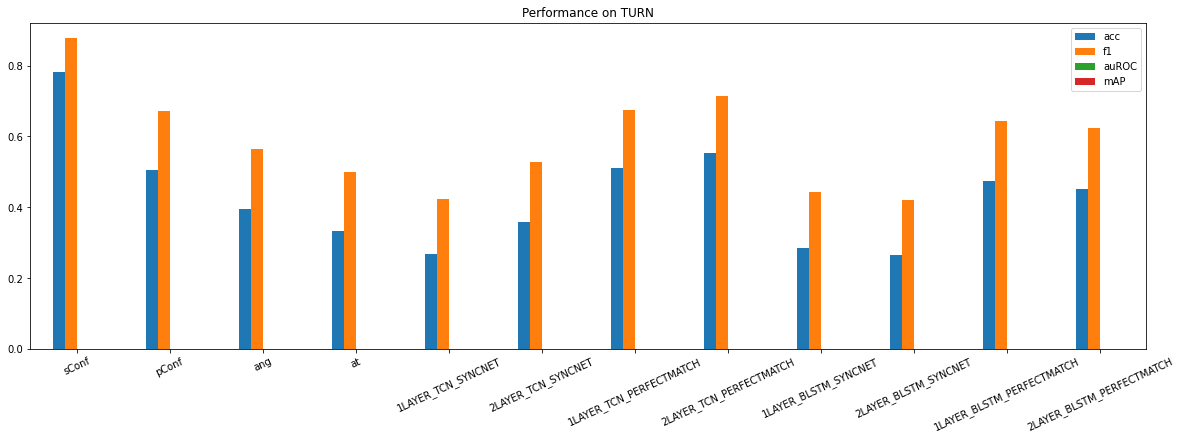

Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0
Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Only one class present in y_true. ROC AUC score is not defined in that case. Class balance is: 0.0


/home/chris/Programs/anaconda3/envs/modenv/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


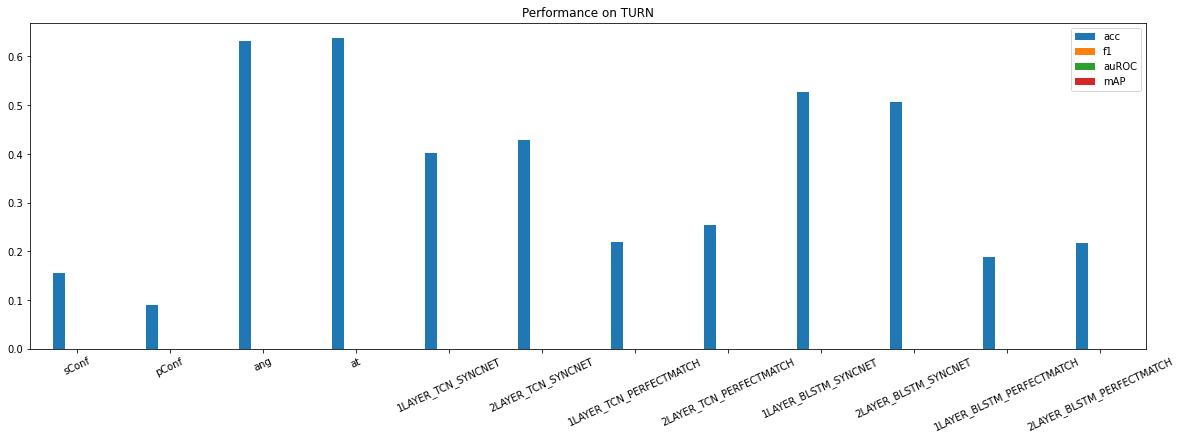

In [9]:
s = score_df(full_df[(full_df[f"SPEECH-LABEL"] ==0) & (full_df[f"TURN-LABEL"] == 1)], label="TURN",print_df=False,plot=True)
s = score_df(full_df[(full_df[f"SPEECH-LABEL"] ==1) & (full_df[f"TURN-LABEL"] == 0)], label="TURN",print_df=False,plot=True)

# Old - Ignore

display(full_df) 
# Plotting Functions

# Comparing Headpose When Models are Correct vs Incorrect

Here we can see that when the models are wrong the headpose tends to be different from when the models are right

In [6]:
def compare_correct_incorrect(plotcolumns, numlayers, model, feature, labeltype):
    print("Correct vs Incorrect When Talking")
    cond1A = full_df[f"{numlayers}LAYER_{labeltype}_{model}_{feature}-1Conf"] >= full_df[f"{numlayers}LAYER_{labeltype}_{model}_{feature}-0Conf"] #TCN thinks speaking
    cond1B = full_df[f"{labeltype}-LABEL"] == 1
    df1 = full_df[plotcolumns][cond1A & cond1B] #correct

    cond2A = full_df[f"{numlayers}LAYER_{labeltype}_{model}_{feature}-1Conf"] < full_df[f"{numlayers}LAYER_{labeltype}_{model}_{feature}-0Conf"] #TCN thinks not speaking
    cond2B = full_df["SPEECH-LABEL"] == 1
    df2 = full_df[plotcolumns][cond2A & cond2B] # incorrect

    data_to_compare = [df1,df2]
    for c in plotcolumns:
        sets = [df[c].values for df in data_to_compare]
        compare_distributions(sets, c, categories=["Correct","Incorrect"], save=False)
        
    print("Correct vs Incorrect When NOT Talking")
    cond1A = full_df[f"{numlayers}LAYER_{labeltype}_{model}_{feature}-1Conf"] < full_df[f"{numlayers}LAYER_{labeltype}_{model}_{feature}-0Conf"] #TCN thinks not speaking
    cond1B = full_df[f"{labeltype}-LABEL"] == 0
    df1 = full_df[plotcolumns][cond1A & cond1B] #correct

    cond2A = full_df[f"{numlayers}LAYER_{labeltype}_{model}_{feature}-1Conf"] >= full_df[f"{numlayers}LAYER_{labeltype}_{model}_{feature}-0Conf"] #TCN thinks speaking
    cond2B = full_df["SPEECH-LABEL"] == 0
    df2 = full_df[plotcolumns][cond2A & cond2B] # incorrect

    data_to_compare = [df2,df1]
    for c in plotcolumns:
        sets = [df[c].values for df in data_to_compare]
        compare_distributions(sets, c, categories=["Correct","Incorrect"], save=False)
        
def compare_correct_incorrect_original(columns, feature, labeltype):
    print("Correct vs Incorrect When Talking")
    cond1A = full_df[feature] >= 0 #Sync thinks speaking
    cond1B = full_df[f"{labeltype}-LABEL"] == 1
    df1 = full_df[columns][cond1A & cond1B] #Correct

    cond2A = full_df[feature] < 0 #Sync thinks not speaking
    cond2B = full_df[f"{labeltype}-LABEL"] == 1
    df2 = full_df[columns][cond2A & cond2B] #Incorrect
    
    print("Comparing head rotation and syncnet performance while talking")
    data_to_compare = [df1,df2]
    for c in columns:
        sets = [df[c].values for df in data_to_compare]
        compare_distributions(sets, c, categories=["Correct","Incorrect"], save=False)

    print("Correct vs Incorrect When NOT Talking")
    cond1A = full_df[feature] < 0 #Sync thinks not speaking
    cond1B = full_df[f"{labeltype}-LABEL"] == 0
    df1 = full_df[columns][cond1A & cond1B] #Correct

    cond2A = full_df[feature] >= 0 #Sync thinks speaking
    cond2B = full_df[f"{labeltype}-LABEL"] == 0
    df2 = full_df[columns][cond2A & cond2B] #Incorrect
    
    print("Comparing head rotation and syncnet performance while NOT talking")
    data_to_compare = [df1,df2]
    for c in columns:
        sets = [df[c].values for df in data_to_compare]
        compare_distributions(sets, c, categories=["Correct","Incorrect"], save=False)

Correct vs Incorrect When Talking


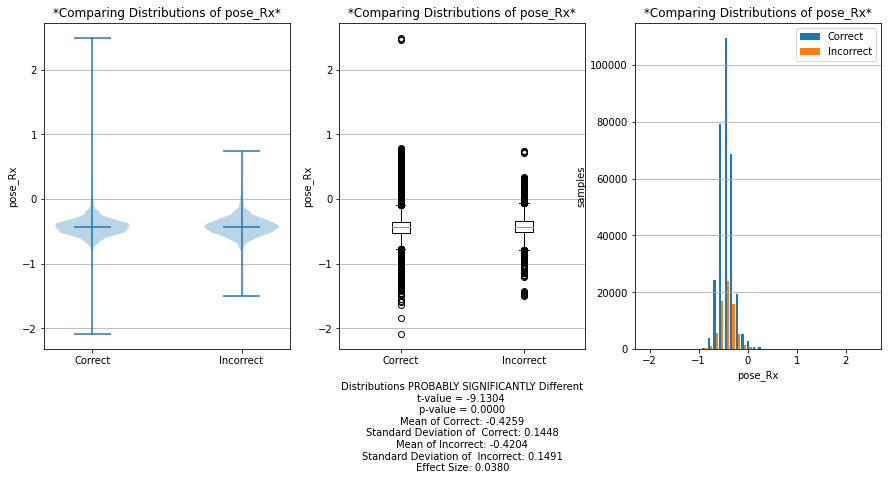

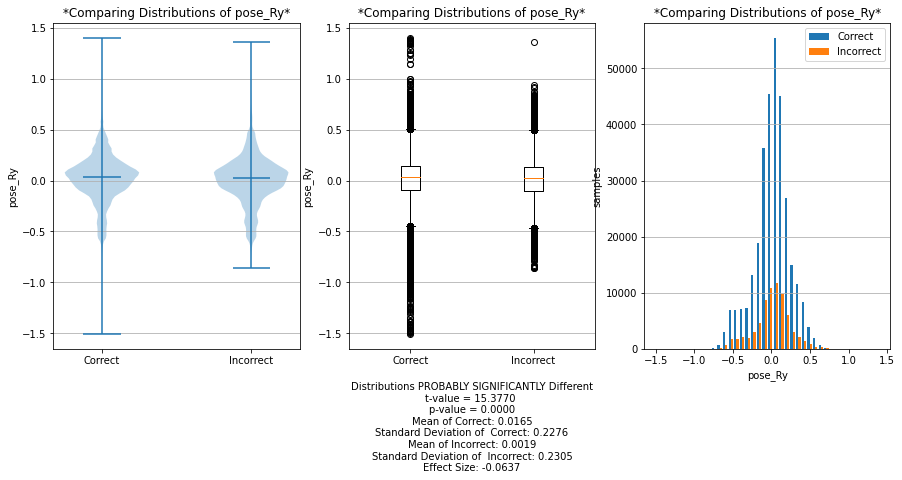

Correct vs Incorrect When NOT Talking


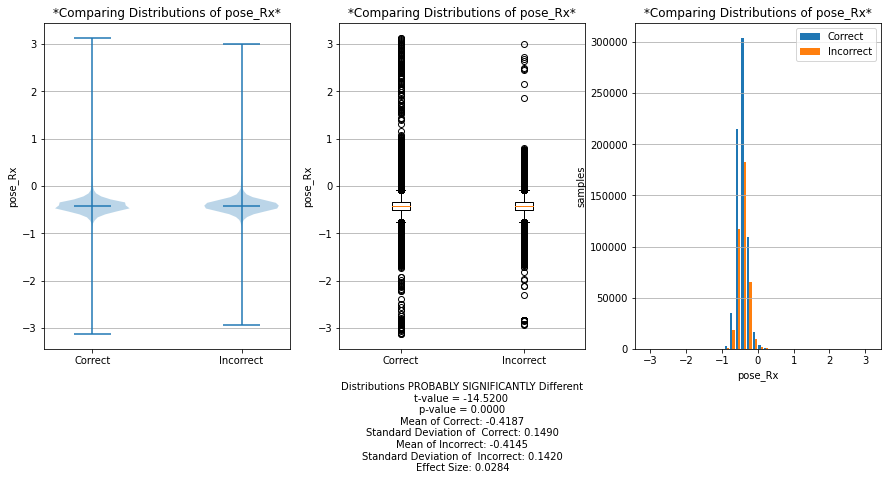

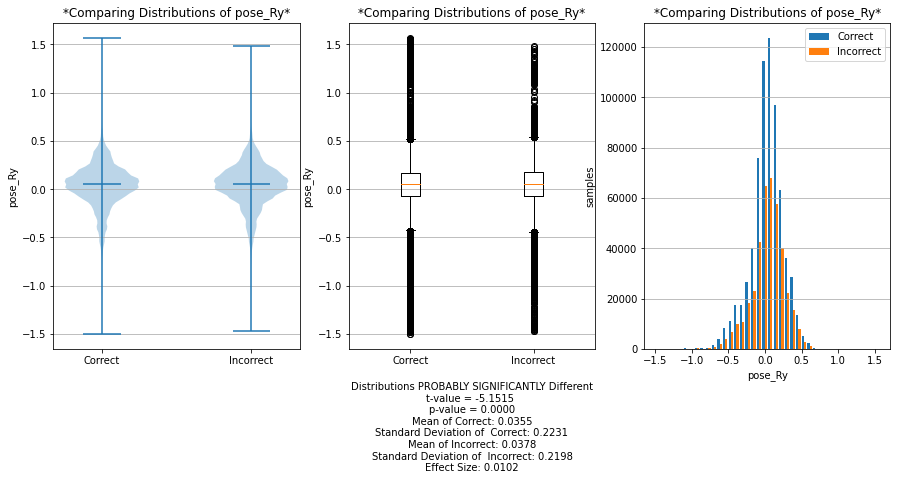

In [76]:
columns = pose
compare_correct_incorrect(pose, 1, "TCN", "PERFECTMATCH", "SPEECH")


Correct vs Incorrect When Talking
Comparing head rotation and syncnet performance while talking


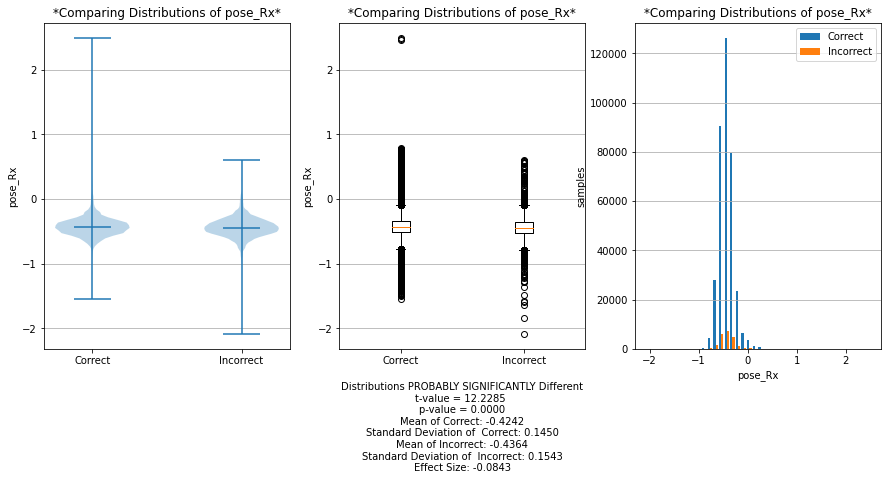

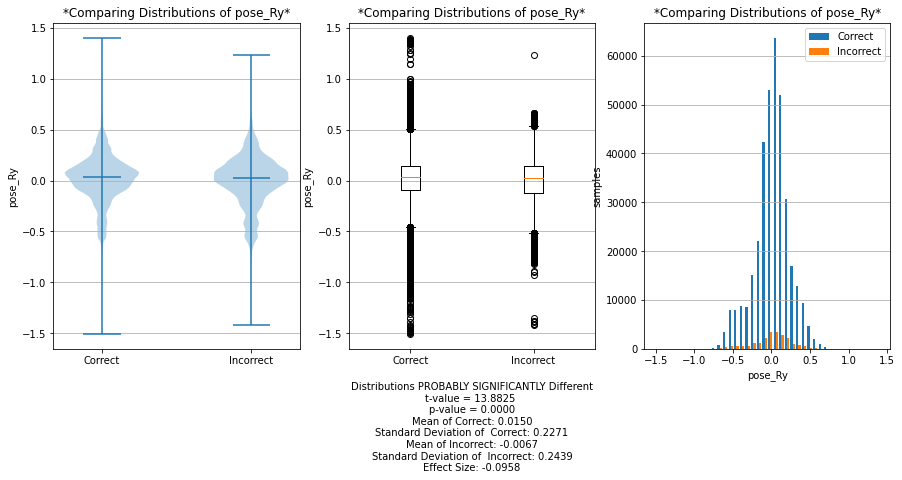

Correct vs Incorrect When NOT Talking
Comparing head rotation and syncnet performance while NOT talking


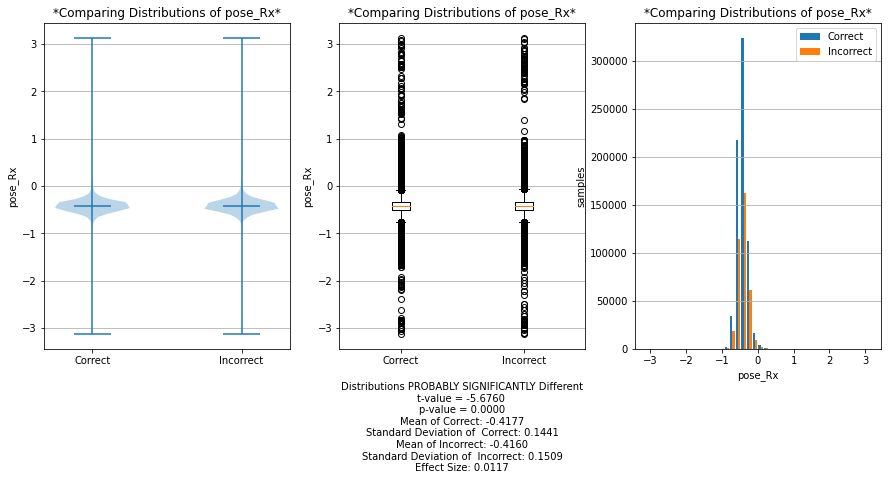

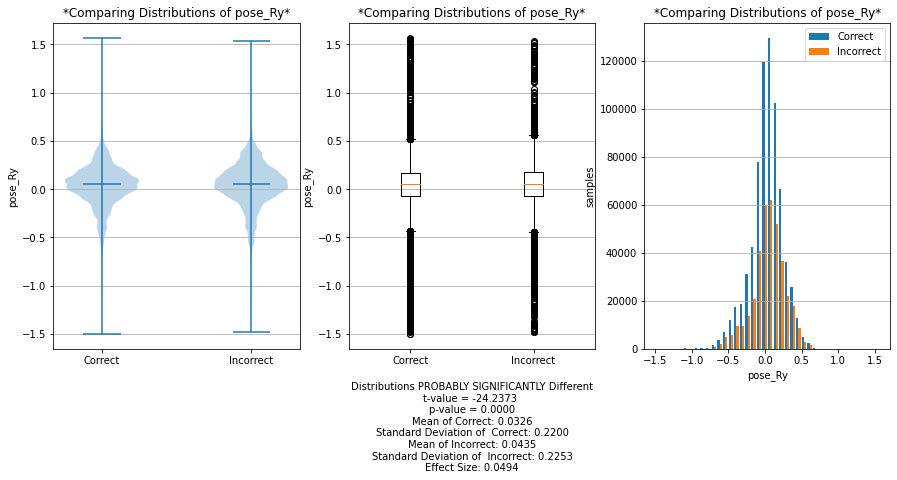

In [81]:
compare_correct_incorrect_original(pose, "pConf", "SPEECH")

In [2]:
def compare_distributions(sets, variable, categories=["A","B"], save=True):
    """ Visualize and test if two distributions are significantly different
    
    Plots violin, box and histogram. Uses t test to compare.
    
    args:
        sets: list of two numpy arrays to compare
        variable: name of the variable under consideration e.g. pose_Rx
        categories: names of subsets of the variable under consideration e.g. [Correct, Incorrect]
    """
    title=f"Comparing Distributions of {variable}"
    max_category_text_size=22
    t, p = stats.ttest_ind(sets[0], sets[1])
     
    text=""
    if p/2 < .05:
        text = "\nDistributions PROBABLY SIGNIFICANTLY Different"
        title = "*"+title+"*"  
    
    text = text+f"\nt-value = {t:.04f} \np-value = {p/2:.04f}"

    categories = [c[:max_category_text_size] for c in categories]
    for i in range(len(categories)):
        text = text + f"\nMean of {categories[i]}: {np.mean(sets[i]):.04f}"
        text = text + f"\nStandard Deviation of  {categories[i]}: {np.std(sets[i]):.04f}"
    text = text + f"\nEffect Size: {(np.mean(sets[1])-np.mean(sets[0]))/np.std(sets[0]):.04f}"
        
        
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

    axes[0].violinplot(sets,showmeans=False,showmedians=True)
    axes[0].set_title(title)

    axes[1].boxplot(sets)
    axes[1].set_title(title)

    axes[2].hist(sets, 40, density=False, histtype='bar', stacked=False, label=categories)
    axes[2].set_title(title)
    axes[2].legend(prop={'size': 10})
    axes[2].set_ylabel("samples")
    axes[2].set_xlabel(variable)

    # adding horizontal grid lines
    for ax in axes:
        ax.yaxis.grid(True)
        if ax != axes[2]:
            ax.set_xticks([y + 1 for y in range(len(sets))])
            ax.set_xlabel("")
            ax.set_ylabel(variable)
    axes[1].set_xlabel(text)
    
    plt.setp(axes[:2], xticks=[y + 1 for y in range(len(sets))],xticklabels=categories)
    plt.show()

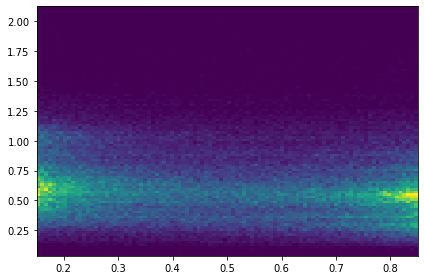

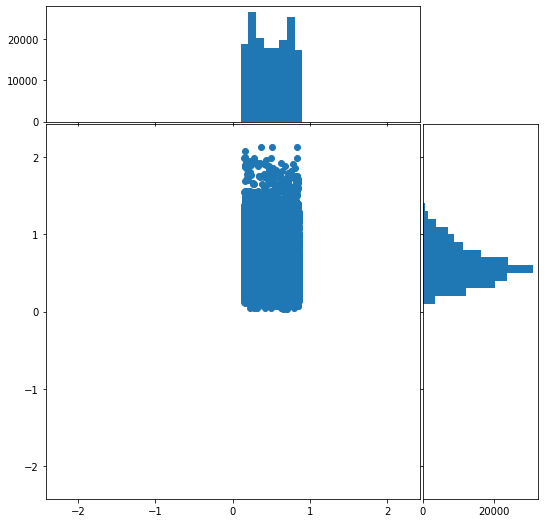

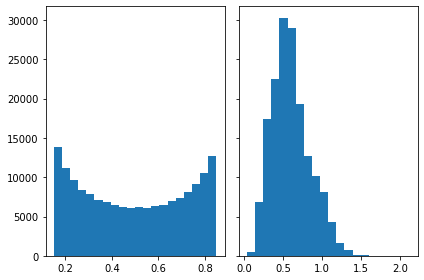

In [73]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

def double_scatter(x,y):    
    fig, ax = plt.subplots(tight_layout=True)
    hist = ax.hist2d(x, y, bins=100)
    plt.show()
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    # use the previously defined function
    scatter_hist(x, y, ax, ax_histx, ax_histy)

    plt.show()

    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    n_bins=20
    # We can set the number of bins with the `bins` kwarg
    axs[0].hist(x, bins=n_bins)
    axs[1].hist(y, bins=n_bins)
    plt.show()
    
d=(all_confidences[:,1]>=0.15) & (all_confidences[:,1]<=0.85)
x = all_confidences[d,1]
y=avg_ang[d]
double_scatter(x,y)